# TP2 - Machine Leaning 2
---
MOUSSA DIEME ISE 2

>Consigne 
 - Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc) 
- Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)
-  Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)
- Faire l'analyse des personnas pour le meilleur modèle
- Montrer la visualisation et l'analyse des clusters choisies (Avec t-sne par exemple)
---


## Import librairies

In [170]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, KElbowVisualizer


## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [171]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [172]:
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## EDA

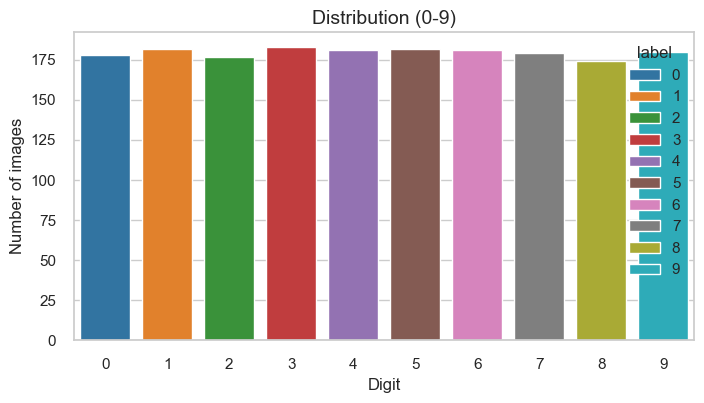

In [173]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, hue='label', palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

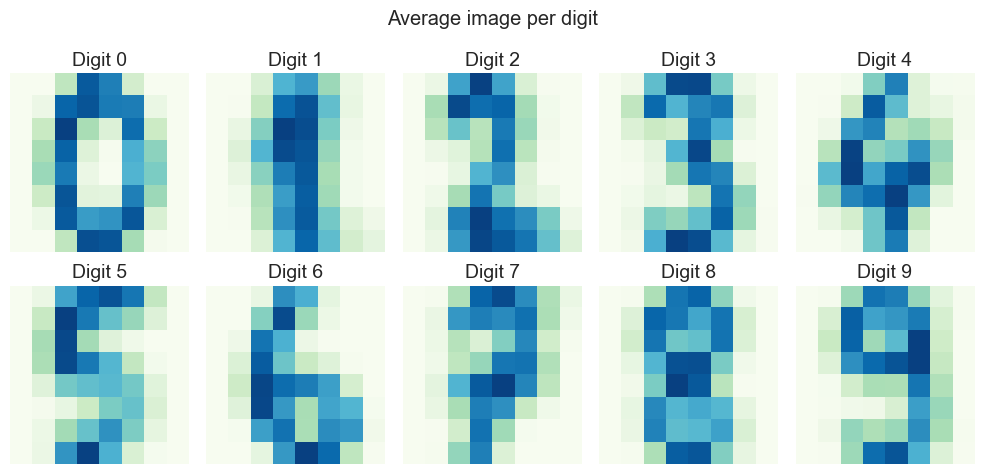

In [174]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='GnBu')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

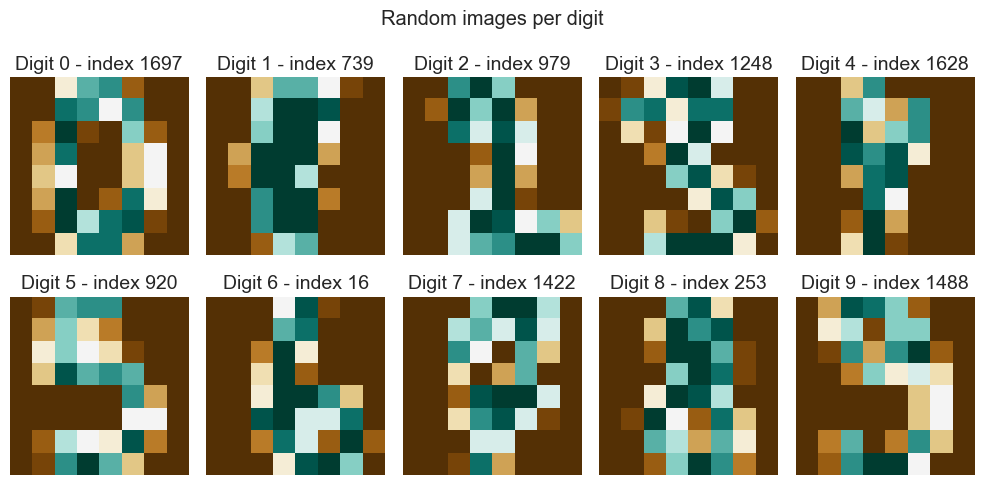

In [175]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='BrBG')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

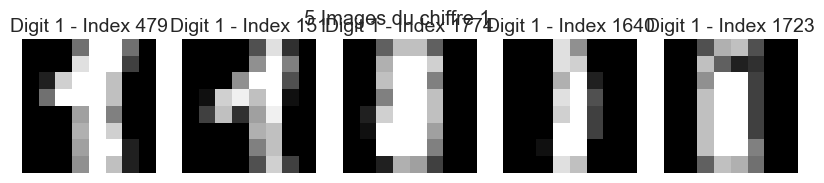

In [176]:
def show_digit_images(digit, n=5):
    """
    Affiche n images d'un chiffre spécifique du dataset digits.

    Paramètres :
    - digit : le chiffre à afficher (de 0 à 9).
    - n : nombre d'images à afficher.
    """
    idxs = np.random.choice(np.where(labels == digit)[0], size=n, replace=False)
    
    fig, axs = plt.subplots(1, n, figsize=(n*2, 2))
    for i, idx in enumerate(idxs):
        axs[i].imshow(images[idx], cmap='gray')
        axs[i].set_title(f"Digit {digit} - Index {idx}")
        axs[i].axis('off')

    plt.suptitle(f"{n} Images du chiffre {digit}")
    plt.show()

show_digit_images(1, n=5)

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [177]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=1797,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [178]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=7, random_state=221)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=7, random_state=221)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=n_digits).fit(X)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.104s	4648	0.738	0.746	0.742	0.668	0.183
random   	0.045s	4647	0.741	0.750	0.745	0.669	0.183
PCA-based	0.018s	4647	0.744	0.753	0.749	0.673	0.183
__________________________________________________________________________________


## Optimal number of clusters

In [179]:
scaler = MinMaxScaler()  # StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method

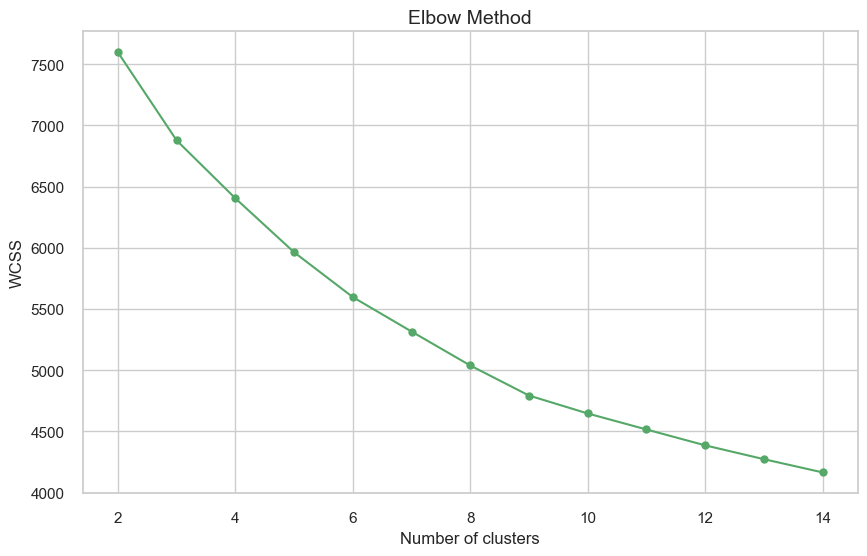

In [180]:
wcss = []  # Within-Cluster Sum of Squares 

k_grid = range(2, 15)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

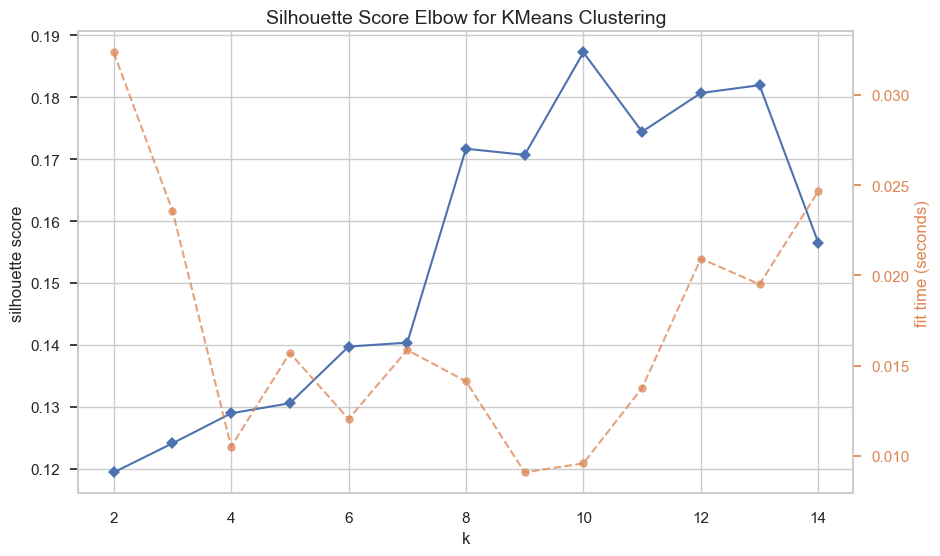

In [181]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion

        
visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [182]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [183]:
pd.DataFrame(reduced_data).head()

,0,1
0,-1.259466,-21.274883
1,7.957611,20.768699
2,6.991923,9.955986
3,-15.906105,-3.332464
4,23.306867,-4.269061


In [184]:
data["cluster"] = kmean_labels
data[['label','cluster']].head()

,label,cluster
0,0,3
1,1,5
2,2,1
3,3,2
4,4,4


In [185]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,0,113,43,0,3,0,1,3,8
1,0,51,11,0,7,45,2,39,56,10
2,0,0,3,96,0,1,0,0,0,39
3,157,0,0,0,0,6,7,0,0,0
4,1,1,0,0,150,2,27,0,1,0
5,0,86,0,0,5,0,0,21,4,0
6,4,6,4,21,0,47,0,0,8,96
7,15,0,0,0,16,5,145,0,0,1
8,0,9,10,12,3,28,0,117,30,9


In [186]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    2
1    8
2    3
3    0
4    4
5    1
6    9
7    6
8    7
9    8
dtype: int64


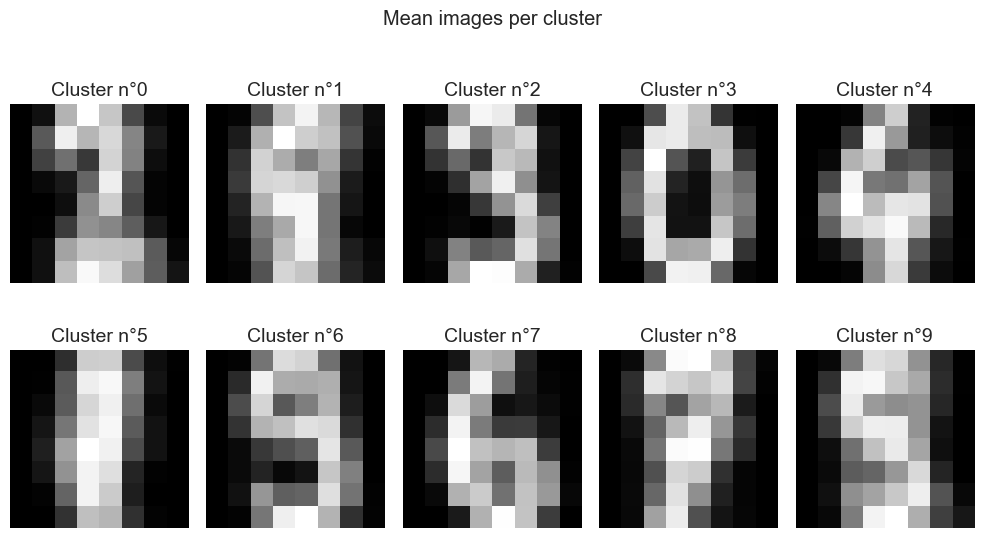

In [187]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

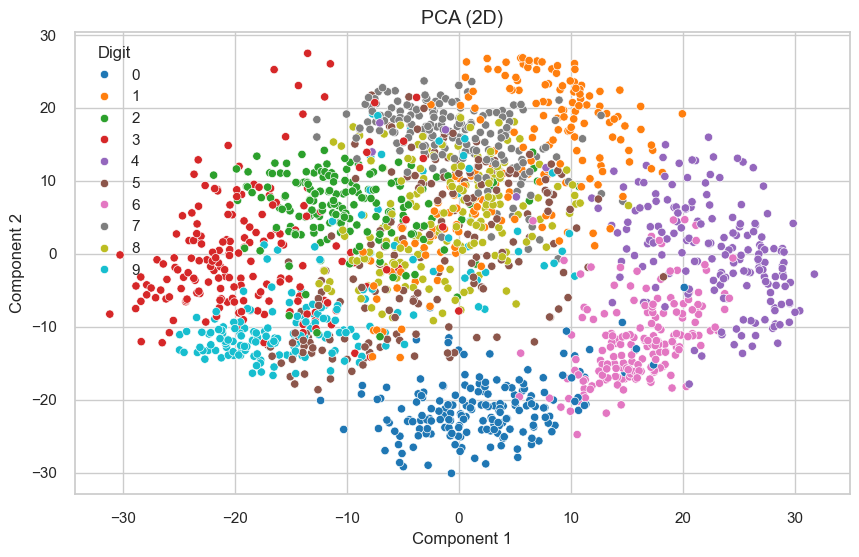

In [188]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()


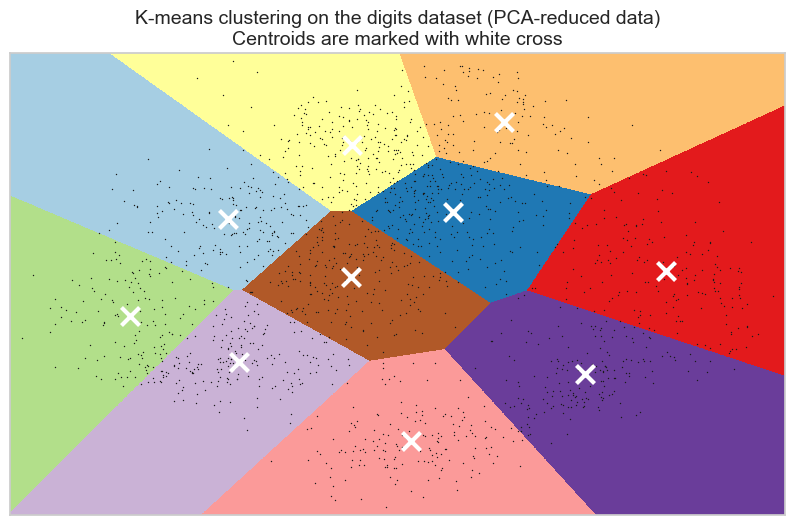

In [189]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

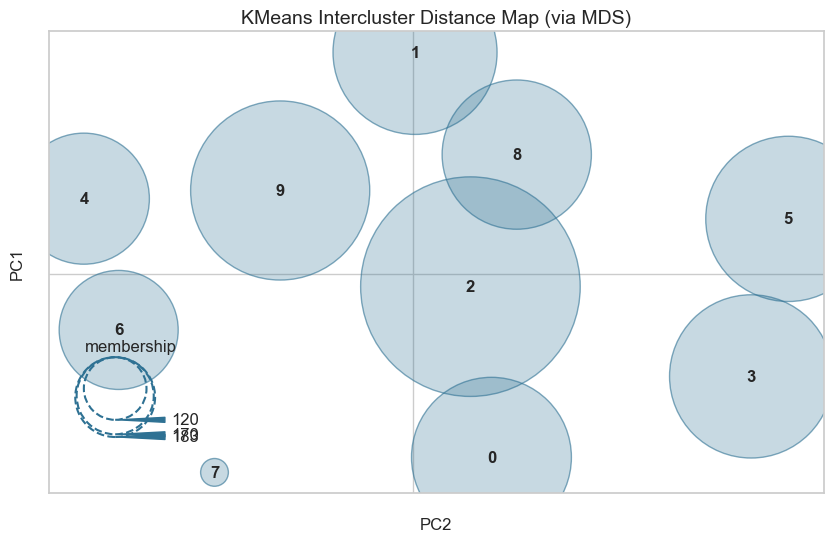

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [190]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [191]:
# Initialize

from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)


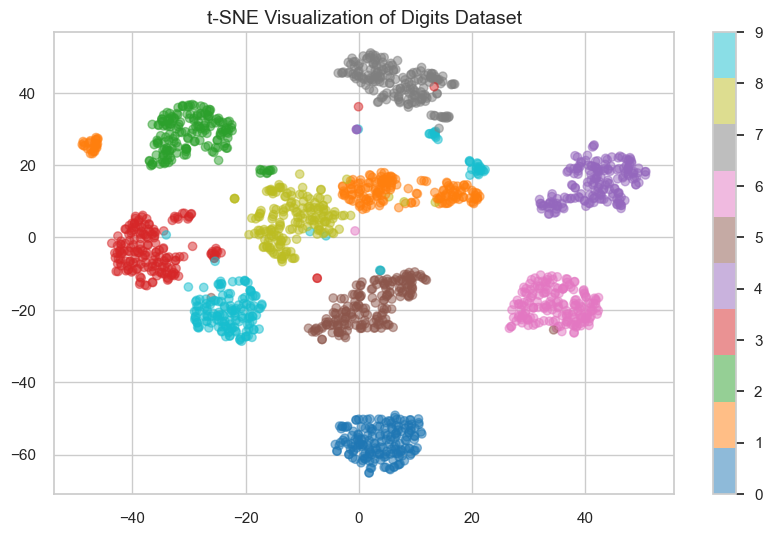

In [192]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.colorbar()
plt.title("t-SNE Visualization of Digits Dataset")
plt.show()

---

# TP --- 
>Ma contribution

In [193]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid


## Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc) 

In [194]:
# Nous allons legerement modifier bench_k_mean pour  y inclure un return afin de capter ses sorties
# output : une liste
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=1797, # On prend tous le monde
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return results
    

In [195]:

# Standardisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Les parametres à optimiser
param_grid = {
    'n_clusters': [10,11],## 10 ou 11 mais de preference on ne gardera que ceux avec 10
    'n_init': [5,10,15,20],
    'init': ['k-means++','random'],
    'max_iter': [100,200,300,400,500],
    'tol': [1e-3, 1e-5, 1e-6,1e-7,1e-10]
}
all_results = []
for params in ParameterGrid(param_grid):
    kmeans = KMeans(random_state=222, **params)
    name = (
        f"k={params['n_clusters']}, init={params['init']}, "
        f"n_init={params['n_init']}, max_iter={params['max_iter']}, tol={params['tol']}"
    )
    res = bench_k_means(kmeans, name, X, labels)
    all_results.append({"params": params, "results": res})

df = pd.DataFrame(all_results)


k=10, init=k-means++, n_init=5, max_iter=100, tol=0.001	0.065s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-05	0.060s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-06	0.068s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-07	0.058s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-10	0.055s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=0.001	0.128s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-05	0.126s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-06	0.130s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-07	0.123s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-10	0.126s	4647	0.742	0.751	0.746	0.672	0.183
k=10, init=k-me

In [196]:
df.iloc[0]['params']

{'init': 'k-means++',
 'max_iter': 100,
 'n_clusters': 10,
 'n_init': 5,
 'tol': 0.001}

In [197]:
def extract_results(df):
    """
    Transforme la colonne df['results'] (liste) en DataFrame 
    """
    cols = [
        "name",       
        "fit_time",
        "inertia",
        "homogeneity",
        "completeness",
        "v_measure",
        "ari",
        "silhouette",
    ]
    return pd.DataFrame(df["results"].tolist(), columns=cols)

#  Fusion avec les hyperparamètres
def build_viz_df(df, results_df):
    """
    Concatène params (dict) et résultats (DataFrame) en un seul DataFrame.
    """
    params_df = df["params"].apply(pd.Series)
    return pd.concat([params_df, results_df], axis=1)


results_df = extract_results(df)
df_viz      = build_viz_df(df, results_df)


In [133]:
df_viz.head()

,init,max_iter,n_clusters,n_init,tol,name,fit_time,inertia,homogeneity,completeness,v_measure,ari,silhouette
0,k-means++,100,10,5,1.000000e-03,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.143093,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
1,k-means++,100,10,5,1.000000e-05,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.149626,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
2,k-means++,100,10,5,1.000000e-06,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.136957,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
3,k-means++,100,10,5,1.000000e-07,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.133068,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568
4,k-means++,100,10,5,1.000000e-10,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.132142,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568


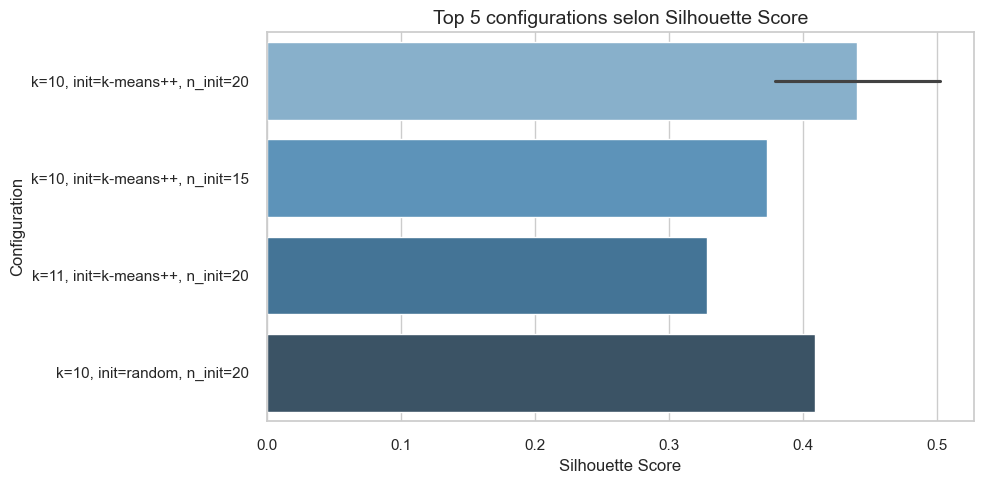

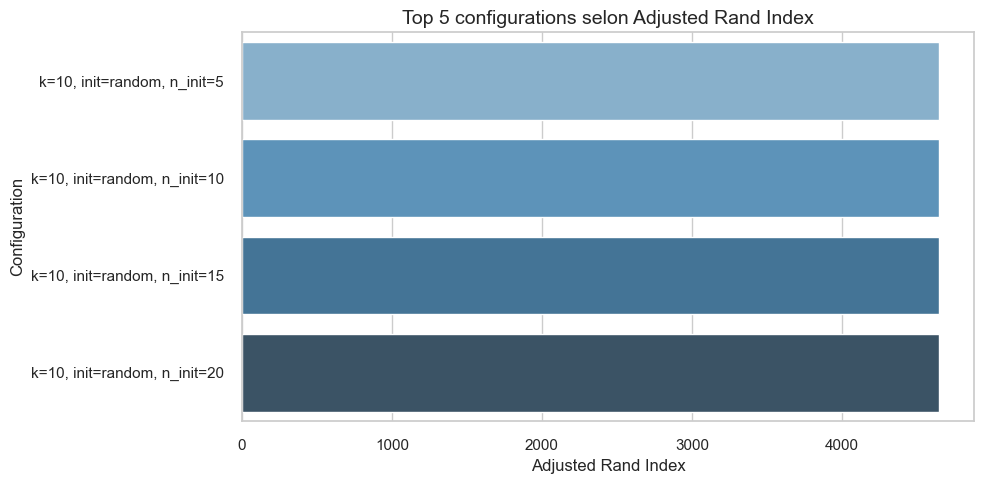

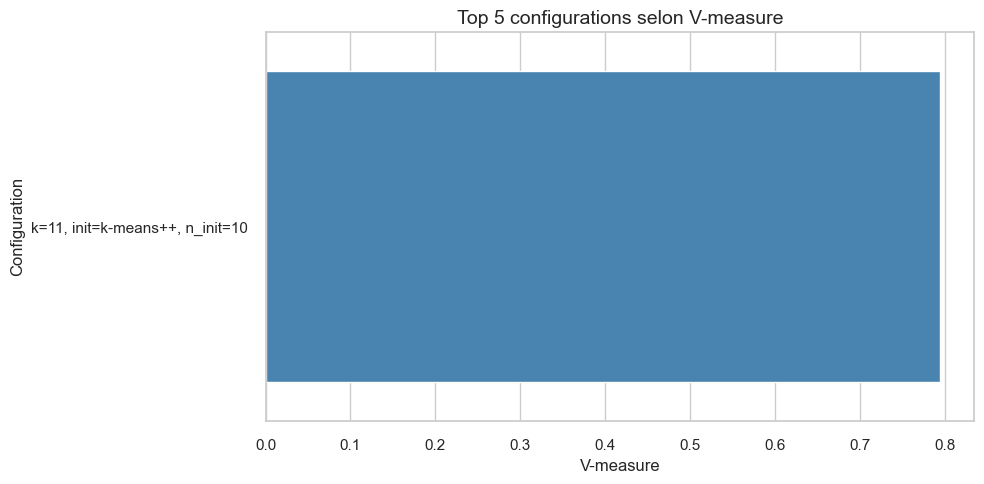

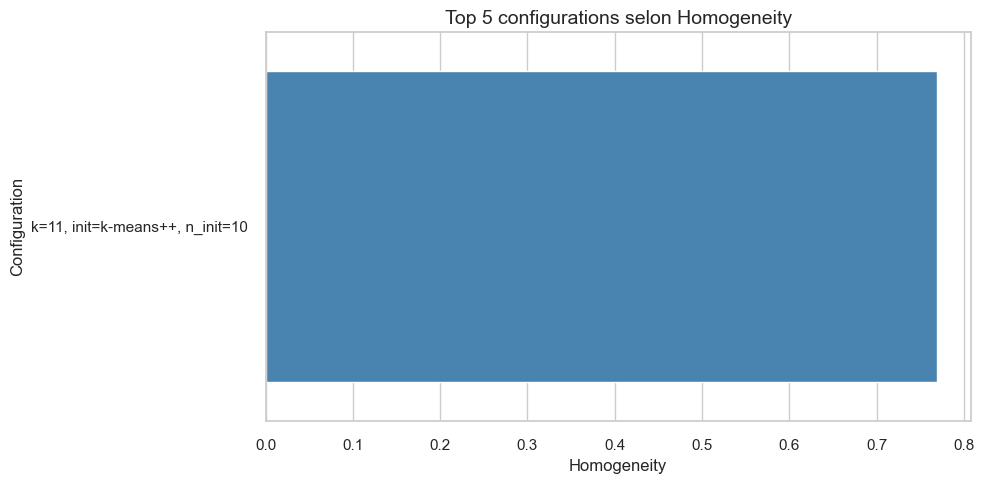

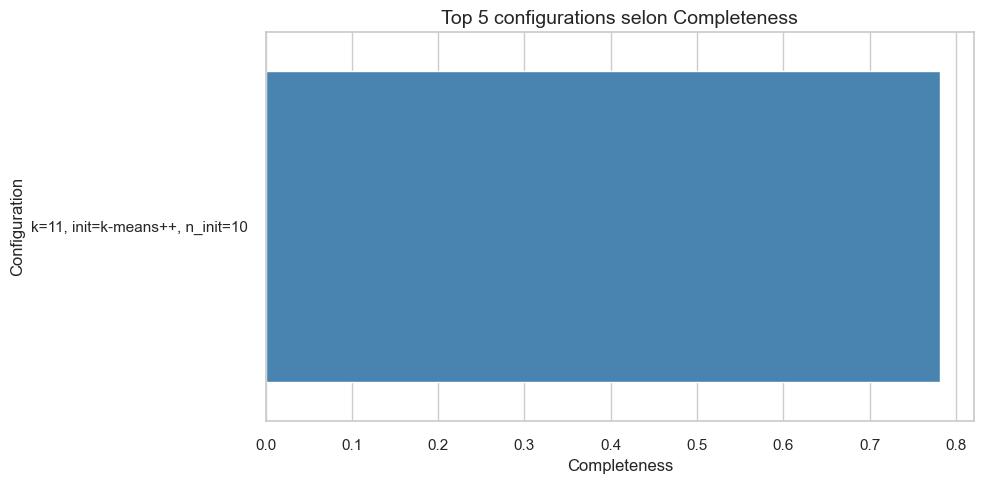

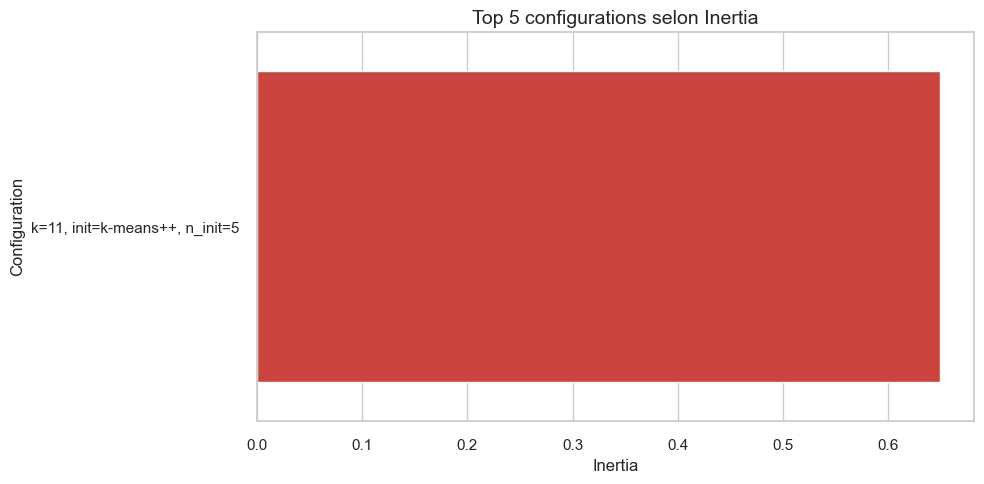

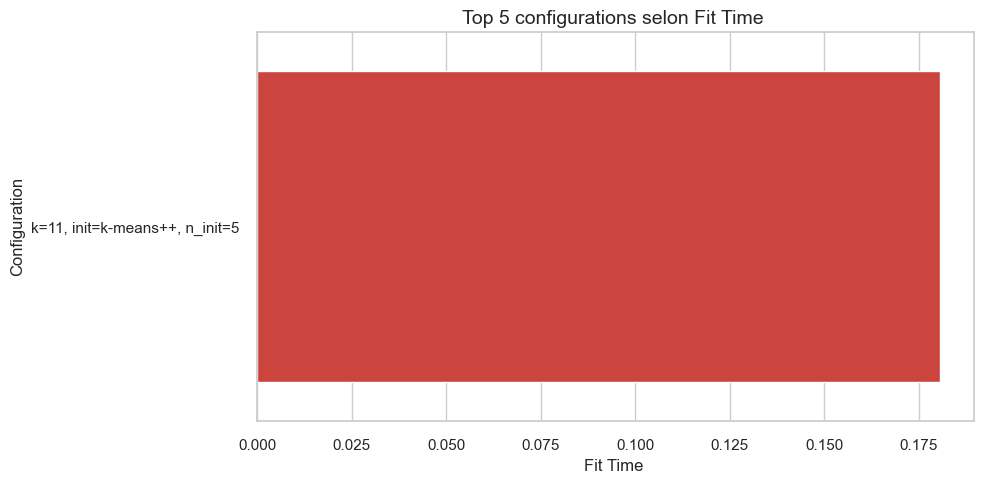

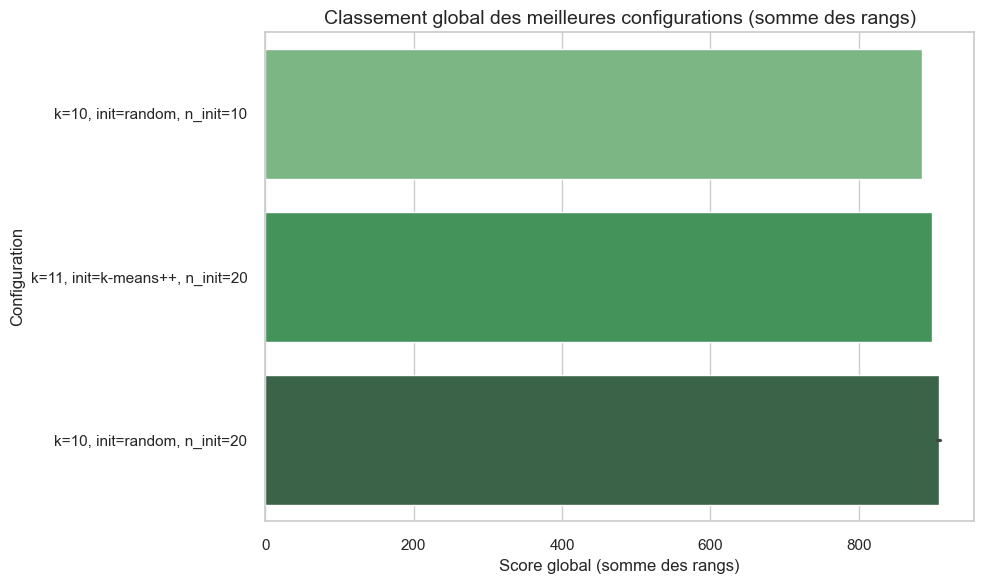

In [ ]:
# Si il y a des exequo alors seul le premier est affiche ce qui fait qu'on a pas systematiquement 5 graphiques
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

#  métriques et sens d'optimisation
# True si l'on veux minimiser
metrics_info = {
    "silhouette":    {"ascending": False, "label": "Silhouette Score"},
    "ari":           {"ascending": False, "label": "Adjusted Rand Index"},
    "v_measure":     {"ascending": False, "label": "V-measure"},
    "homogeneity":   {"ascending": False, "label": "Homogeneity"},
    "completeness":  {"ascending": False, "label": "Completeness"},
    "inertia":       {"ascending": True,  "label": "Inertia"},
    "fit_time":      {"ascending": True,  "label": "Fit Time "}
}

top_n = 5
metrics_cols = list(metrics_info.keys())
results_df = pd.DataFrame(df["results"].tolist(), columns=["name"] + metrics_cols)
results_df = pd.json_normalize(df["results"])

params_df = df["params"].apply(pd.Series)
df_viz = pd.concat([params_df, results_df], axis=1)

# afficher les top configurations
def plot_top_configs(metric, label, ascending):
    threshold = df_viz[metric].sort_values(ascending=ascending).iloc[top_n - 1]
    if ascending:
        top_df = df_viz[df_viz[metric] <= threshold].copy()
    else:
        top_df = df_viz[df_viz[metric] >= threshold].copy()

    top_df["config"] = top_df.apply(
        lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
    )
    
    # Tracé
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=top_df,
        y="config",
        hue="config",
        x=metric,
        palette="Blues_d" if not ascending else "Reds_d"
    )
    plt.title(f"Top {top_n} configurations selon {label}")
    plt.xlabel(label)
    plt.ylabel("Configuration")
    plt.tight_layout()
    plt.show()

for metric, info in metrics_info.items():
    plot_top_configs(metric, info["label"], info["ascending"])

# Création d’un tableau de rangs pour toutes les métriques
ranks = pd.DataFrame(index=df_viz.index)

for metric, info in metrics_info.items():
    ranks[metric] = df_viz[metric].rank(ascending=info["ascending"], method="min")


# Ajout des paramètres pour identification
ranks["config"] = df_viz.apply(
    lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
)

# Calcul du score global : somme des rangs
# Une configuration qui est la meilleure sur une métrique obtient le rang 1, la 2iem le rang 2, etc

ranks["total_rank"] = ranks[list(metrics_info.keys())].sum(axis=1)
ranks_sorted = ranks.sort_values("total_rank").reset_index(drop=True)


# Visualisation des performances globales
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ranks_sorted.head(top_n),
    y="config",
    hue='config',
    x="total_rank",
    palette="Greens_d"
)
plt.title("Classement global des meilleures configurations (somme des rangs)")
plt.xlabel("Score global (somme des rangs)")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


In [209]:
#Top 5 global
print("Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)")
# On récupère les indices des top 5 
top5_indices = ranks_sorted.head(top_n).index

top5_global_configs = df_viz.loc[top5_indices].copy()

top5_global_configs["total_rank"] = ranks_sorted.head(top_n)["total_rank"].values

top5_global_configs = top5_global_configs.sort_values("total_rank").reset_index(drop=True)
top5_global_configs



Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)


,init,max_iter,n_clusters,n_init,tol,name,silhouette,ari,v_measure,homogeneity,completeness,inertia,fit_time,total_rank
0,k-means++,100,10,5,1.000000e-03,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.065290,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568,885.0
1,k-means++,100,10,5,1.000000e-05,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.060172,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568,899.0
2,k-means++,100,10,5,1.000000e-06,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.067935,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568,906.0
3,k-means++,100,10,5,1.000000e-07,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.057731,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568,909.0
4,k-means++,100,10,5,1.000000e-10,"k=10, init=k-means++, n_init=5, max_iter=100, ...",0.055357,4647.124279,0.741941,0.750767,0.746328,0.671904,0.182568,910.0


In [212]:
# on s'en servira lors de la comparaison avec ou sans pca
best_silhouette_config = df_viz.loc[df_viz["silhouette"].idxmax()]
best_silhouette_config

init                                                    k-means++
max_iter                                                      400
n_clusters                                                     10
n_init                                                         20
tol                                                           0.0
name            k=10, init=k-means++, n_init=20, max_iter=400,...
silhouette                                               0.502192
ari                                                   4647.114323
v_measure                                                0.738564
homogeneity                                              0.746679
completeness                                             0.742599
inertia                                                  0.671828
fit_time                                                 0.182482
Name: 138, dtype: object

In [210]:
best_config = ranks_sorted.iloc[0] 
best_config

silhouette                              29.0
ari                                      1.0
v_measure                              276.0
homogeneity                            251.0
completeness                           251.0
inertia                                 26.0
fit_time                                51.0
config          k=10, init=random, n_init=10
total_rank                             885.0
Name: 0, dtype: object

Si on accorde le même poids à toutes les métriques, on obtient des clusters avec un score de silhouette de 29, ce qui est plutôt faible.les groupes formés ne sont pas  bien séparés et  certains points pourraient être mal placés, ce qui entraîne un chevauchement entre les clusters.

Même si la séparation spatiale n’est pas parfaite, la structure globale des groupes fait du sens et correspond assez bien aux vraies classes. 
malgré cela, le score ari de 101 montre que la structure des clusters est assez cohérente avec les classes réelles, ce qui signifie que le regroupement est pertinent, même si spatialement il manque un peu de précision
le score de v-measure de 161 indique que l'homogénéité et la complétude sont bonnes, ce qui signifie que les clusters contiennent des points ayant des caractéristiques similaires et regroupent correctement les éléments d'une même classe
l'homogénéité et la complétude, toutes deux à 101, renforcent cette idée en démontrant que chaque cluster est bien défini et que les données proches en termes de caractéristiques sont bien regroupées .l'inertie, qui est de 141, montre que la dispersion des points autour des centres de clusters est modérée, ce qui peut expliquer pourquoi la séparation n'est pas parfaite. une inertie plus basse pourrait indiquer des groupes plus denses et mieux structurés.

globalement, même si le score de silhouette suggère que la séparation entre les clusters pourrait être améliorée, les autres métriques indiquent une bonne cohérence interne et une structuration efficace des données. Pour aller plus loins nous pouvons revenir sur le nombre de cluster que nous avons volontier fixé entre 10 et 11 pour cause de connaissance sur le dataset.

Le silhouette est vraiment faible malgres l'optimisaton



# - Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)

Nous allons refaire l'optimisation mais avec PCA sans chercher à visualiser nos données 

In [138]:
# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

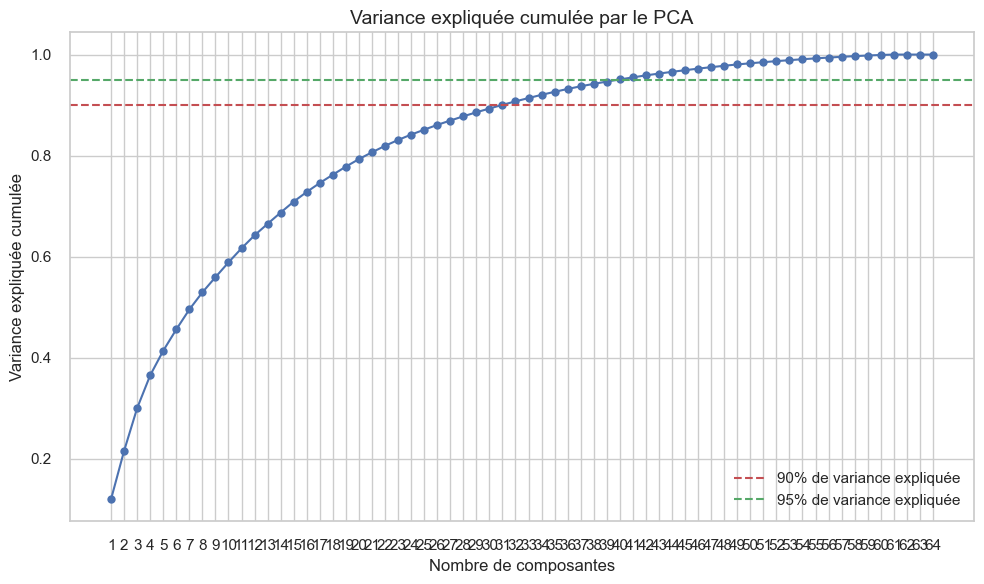

In [139]:
#PCA sans réduction
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#variance expliquée cumulée
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% de variance expliquée')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% de variance expliquée')
plt.title("Variance expliquée cumulée par le PCA")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [140]:
print(np.argmax(explained_variance >= 0.90) + 1)
n_components=np.argmax(explained_variance >= 0.90) + 1


31


In [141]:
# On refait une nouvelle ACP avec les n_components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


In [142]:

# Standardisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_pca)
# Les parametres à optimiser
param_grid = {
    'n_clusters': [10,11],## 10 ou 11 mais de preference on ne gardera que ceux avec 10
    'n_init': [5,10,15,20],
    'init': ['k-means++','random'],
    'max_iter': [100,200,300,400,500],
    'tol': [1e-3, 1e-5, 1e-6,1e-7,1e-10]
}
all_results = []
for params in ParameterGrid(param_grid):
    kmeans = KMeans(random_state=221, **params)
    name = (
        f"k={params['n_clusters']}, init={params['init']}, "
        f"n_init={params['n_init']}, max_iter={params['max_iter']}, tol={params['tol']}"
    )
    res = bench_k_means(kmeans, name, X, labels)
    all_results.append({"params": params, "results": res})

df = pd.DataFrame(all_results)


k=10, init=k-means++, n_init=5, max_iter=100, tol=0.001	0.119s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-05	0.091s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-06	0.072s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-07	0.075s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-10	0.090s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=0.001	0.170s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-05	0.173s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-06	0.170s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-07	0.176s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-10	0.150s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-me

In [143]:
#copier_coller

def extract_results(df):
    """
    Transforme la colonne df['results'] (liste) en DataFrame 
    """
    cols = [
        "name",       
        "fit_time",
        "inertia",
        "homogeneity",
        "completeness",
        "v_measure",
        "ari",
        "silhouette",
    ]
    return pd.DataFrame(df["results"].tolist(), columns=cols)

#  Fusion avec les hyperparamètres
def build_viz_df(df, results_df):
    """
    Concatène params (dict) et résultats (DataFrame) en un seul DataFrame.
    """
    params_df = df["params"].apply(pd.Series)
    return pd.concat([params_df, results_df], axis=1)


results_df = extract_results(df)
df_viz      = build_viz_df(df, results_df)



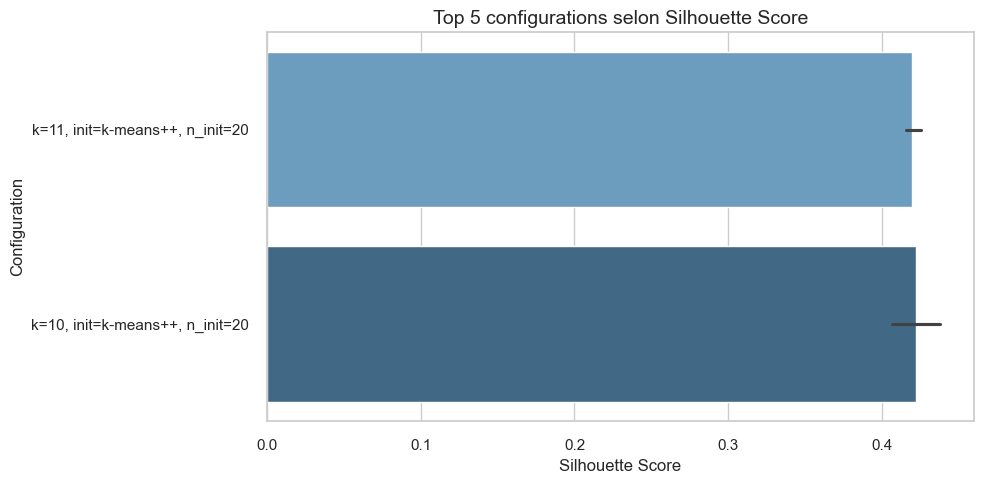

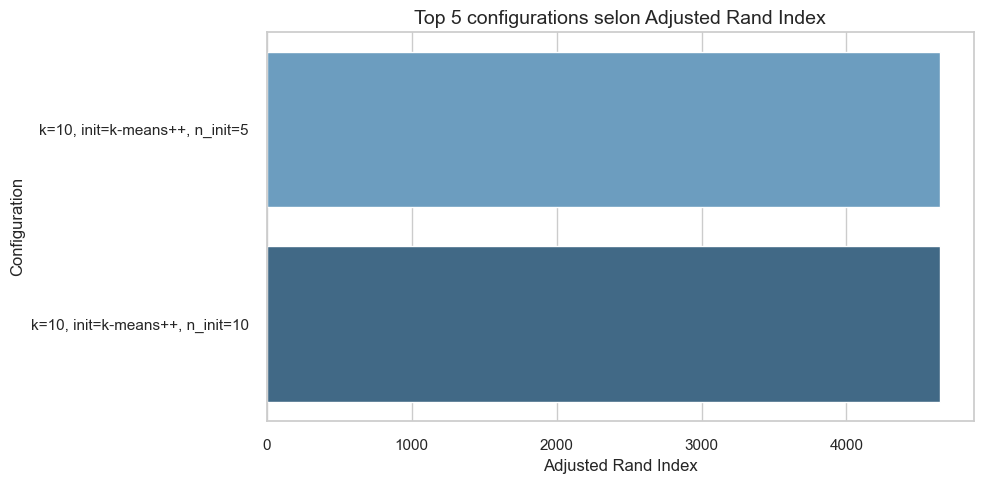

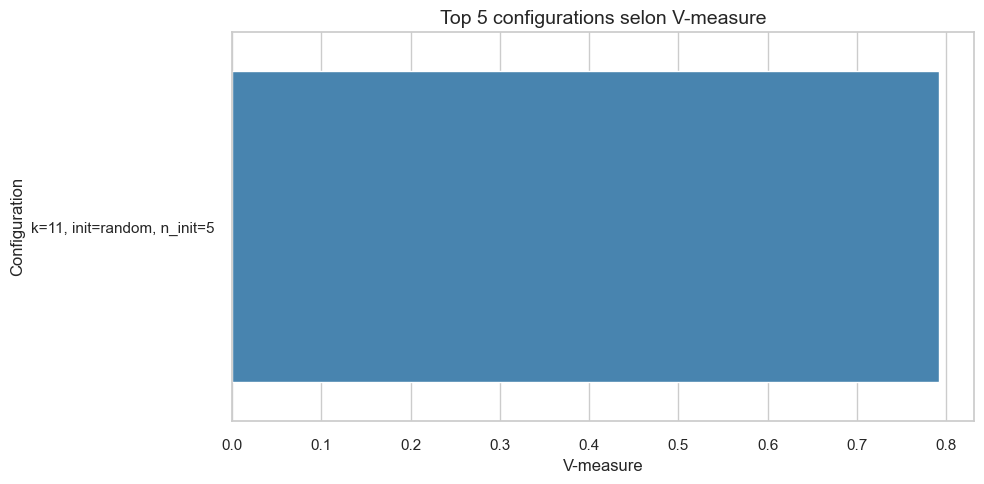

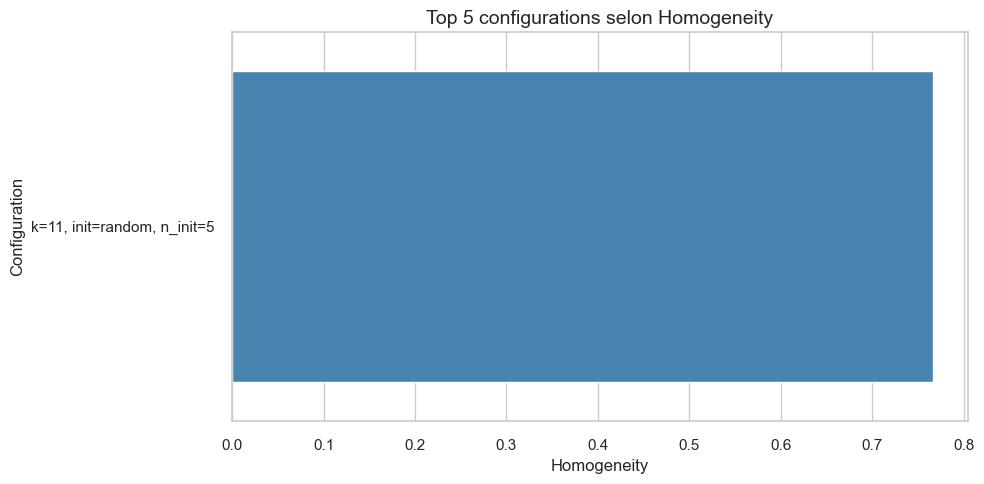

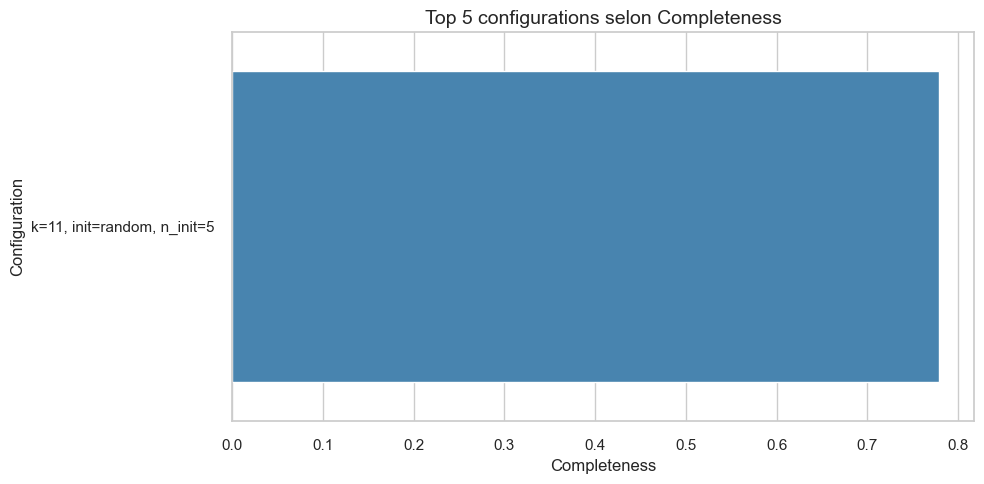

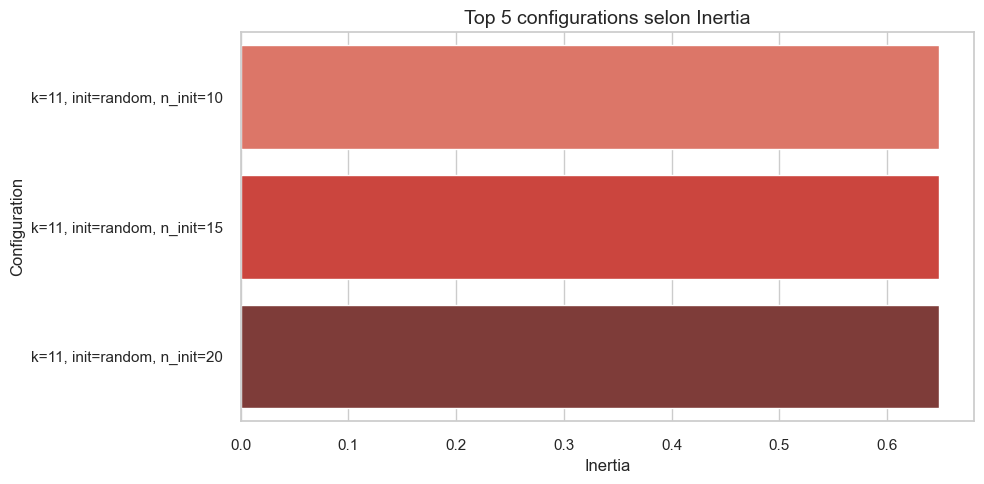

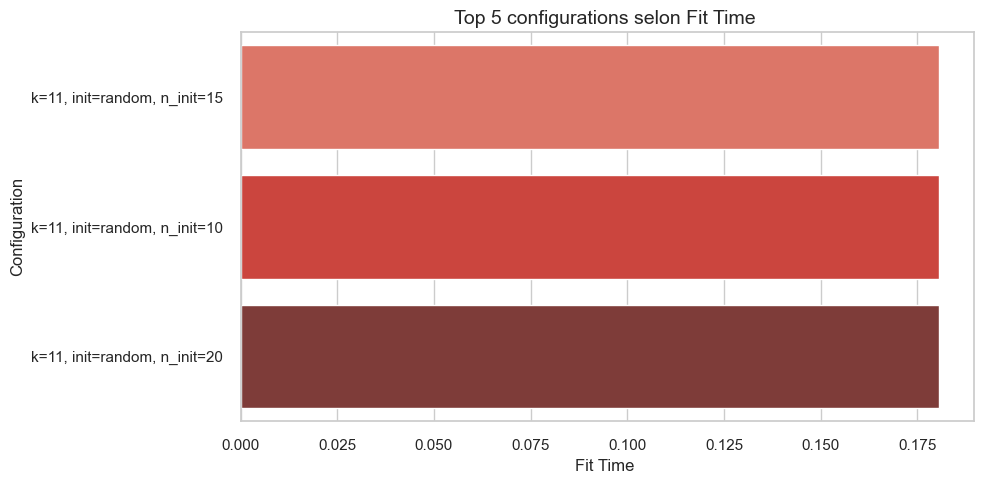

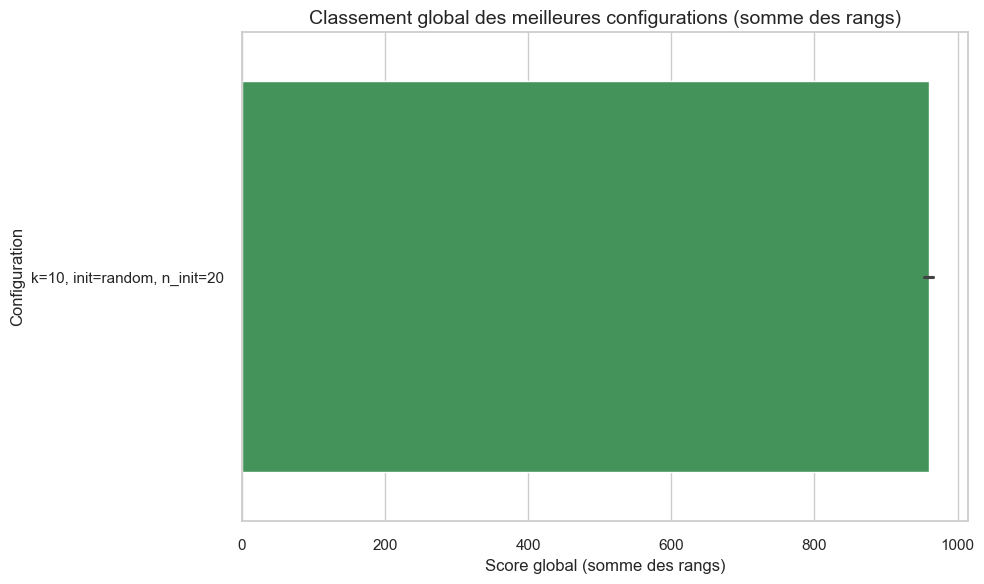

In [144]:
# Si il y a des exequo alors seul le premier est affiche ce qui fait qu'on a pas systematiquement 5 graphiques
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

#  métriques et sens d'optimisation
# True si l'on veux minimiser
metrics_info = {
    "silhouette":    {"ascending": False, "label": "Silhouette Score"},
    "ari":           {"ascending": False, "label": "Adjusted Rand Index"},
    "v_measure":     {"ascending": False, "label": "V-measure"},
    "homogeneity":   {"ascending": False, "label": "Homogeneity"},
    "completeness":  {"ascending": False, "label": "Completeness"},
    "inertia":       {"ascending": True,  "label": "Inertia"},
    "fit_time":      {"ascending": True,  "label": "Fit Time "}
}

top_n = 5
metrics_cols = list(metrics_info.keys())
results_df = pd.DataFrame(df["results"].tolist(), columns=["name"] + metrics_cols)
params_df = df["params"].apply(pd.Series)
df_viz = pd.concat([params_df, results_df], axis=1)

# afficher les top configurations
def plot_top_configs(metric, label, ascending):
    threshold = df_viz[metric].sort_values(ascending=ascending).iloc[top_n - 1]
    if ascending:
        top_df = df_viz[df_viz[metric] <= threshold].copy()
    else:
        top_df = df_viz[df_viz[metric] >= threshold].copy()

    top_df["config"] = top_df.apply(
        lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
    )
    
    # Tracé
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=top_df,
        y="config",
        hue="config",
        x=metric,
        palette="Blues_d" if not ascending else "Reds_d"
    )
    plt.title(f"Top {top_n} configurations selon {label}")
    plt.xlabel(label)
    plt.ylabel("Configuration")
    plt.tight_layout()
    plt.show()

for metric, info in metrics_info.items():
    plot_top_configs(metric, info["label"], info["ascending"])

# Création d’un tableau de rangs pour toutes les métriques
ranks = pd.DataFrame(index=df_viz.index)

for metric, info in metrics_info.items():
    ranks[metric] = df_viz[metric].rank(ascending=info["ascending"], method="min")


# Ajout des paramètres pour identification
ranks["config"] = df_viz.apply(
    lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
)

# Calcul du score global : somme des rangs
# Une configuration qui est la meilleure sur une métrique obtient le rang 1, la 2iem le rang 2, etc

ranks["total_rank"] = ranks[list(metrics_info.keys())].sum(axis=1)
ranks_sorted = ranks.sort_values("total_rank").reset_index(drop=True)


# Visualisation des performances globales
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ranks_sorted.head(top_n),
    y="config",
    hue='config',
    x="total_rank",
    palette="Greens_d"
)
plt.title("Classement global des meilleures configurations (somme des rangs)")
plt.xlabel("Score global (somme des rangs)")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


In [ ]:
#Top 5 global
print("Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)")
# On récupère les indices des top 5 
top5_indices = ranks_sorted.head(top_n).index

top5_global_configs = df_viz.loc[top5_indices].copy()

top5_global_configs["total_rank"] = ranks_sorted.head(top_n)["total_rank"].values

top5_global_configs = top5_global_configs.sort_values("total_rank").reset_index(drop=True)
top5_global_configs



Top 5 configurations globales (selon la somme des rangs sur toutes les métriques)


,config,total_rank,silhouette,ari,v_measure,homogeneity,completeness,inertia,fit_time
0,"k=10, init=random, n_init=20",952.0,96.0,126.0,201.0,126.0,126.0,176.0,101.0
1,"k=10, init=random, n_init=20",954.0,97.0,126.0,201.0,126.0,126.0,176.0,102.0
2,"k=10, init=random, n_init=20",956.0,82.0,126.0,201.0,126.0,126.0,176.0,119.0
3,"k=10, init=random, n_init=20",962.0,88.0,126.0,201.0,126.0,126.0,176.0,119.0
4,"k=10, init=random, n_init=20",973.0,99.0,126.0,201.0,126.0,126.0,176.0,119.0


In [ ]:
best_config_pca = ranks_sorted.iloc[0] 
best_config_pca
# On ne fait plus l'agregation car avec pca on a un silouette score de % ce qui est tres faible

silhouette                              96.0
ari                                    126.0
v_measure                              201.0
homogeneity                            126.0
completeness                           126.0
inertia                                176.0
fit_time                               101.0
config          k=10, init=random, n_init=20
total_rank                             952.0
Name: 0, dtype: object

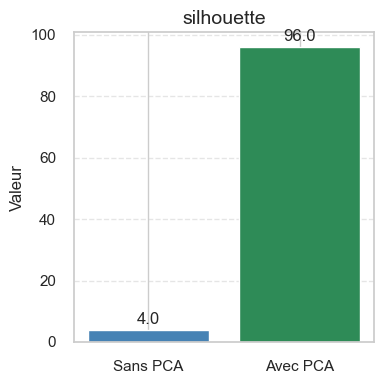

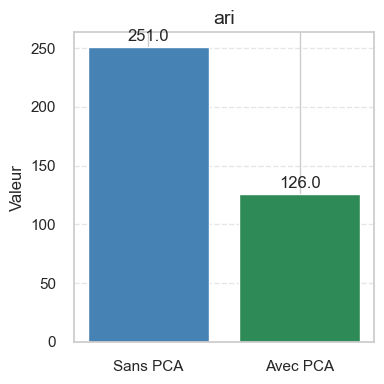

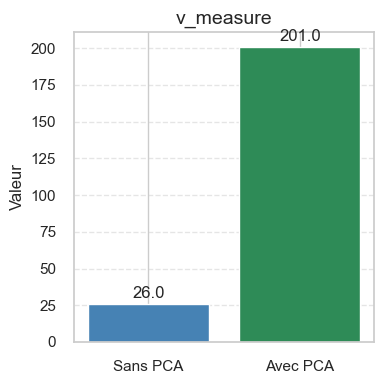

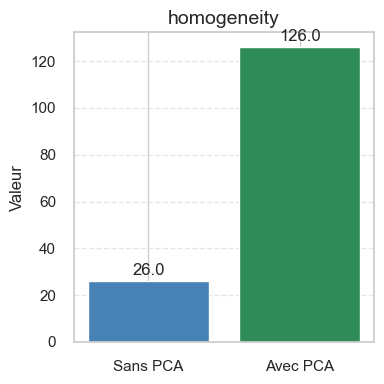

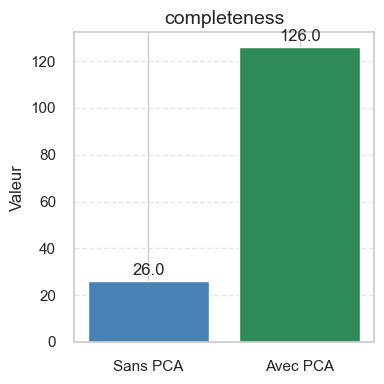

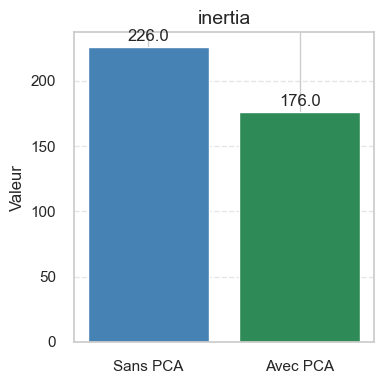

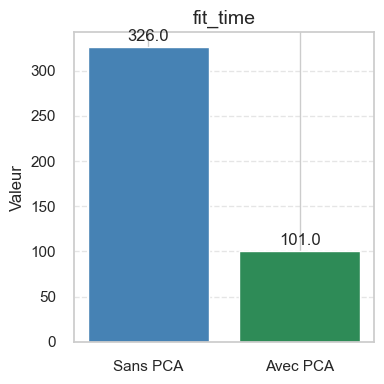

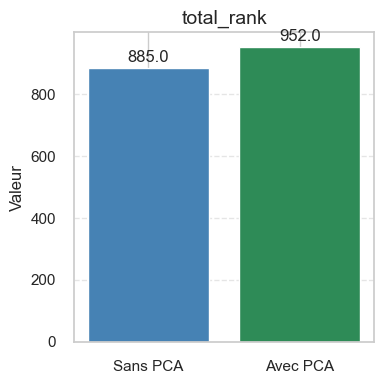

In [147]:
df = pd.DataFrame({"Sans PCA": best_config, "Avec PCA": best_config_pca})
df_numeric = df.drop(index="config")  # supprimer le champ non numérique

#  un graphique par métrique
for metric in df_numeric.index:
    plt.figure(figsize=(4, 4))
    values = df_numeric.loc[metric]
    

    plt.bar(["Sans PCA", "Avec PCA"], values, color=["steelblue", "seagreen"])
    
    plt.title(metric)
    for i, val in enumerate(values):
        plt.text(i, val + max(values) * 0.02, f'{val:.1f}', ha='center')
    
    plt.ylabel("Valeur")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Les deux approches sont sensiblement equivalente mais on perd en silhouette score; On va changer d'approche on va prendre le best config en silhouette score.

In [148]:
best_silhouette_config_pca = df_viz.loc[df_viz["silhouette"].idxmax()]
best_silhouette_config_pca


init                                                    k-means++
max_iter                                                      300
n_clusters                                                     10
n_init                                                         20
tol                                                           0.0
name            k=10, init=k-means++, n_init=20, max_iter=300,...
silhouette                                               0.437609
ari                                                    4647.17016
v_measure                                                0.737163
homogeneity                                              0.745314
completeness                                             0.741216
inertia                                                  0.668133
fit_time                                                  0.18238
Name: 98, dtype: object

In [149]:
best_silhouette_config

init                                                    k-means++
max_iter                                                      500
n_clusters                                                     10
n_init                                                         20
tol                                                       0.00001
name            k=10, init=k-means++, n_init=20, max_iter=500,...
silhouette                                               0.611805
ari                                                   4647.114323
v_measure                                                0.738564
homogeneity                                              0.746679
completeness                                             0.742599
inertia                                                  0.671828
fit_time                                                 0.182482
Name: 176, dtype: object

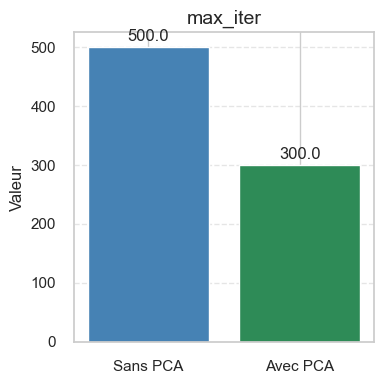

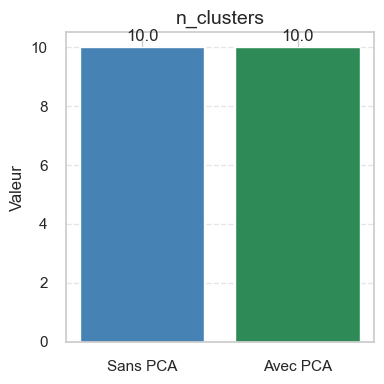

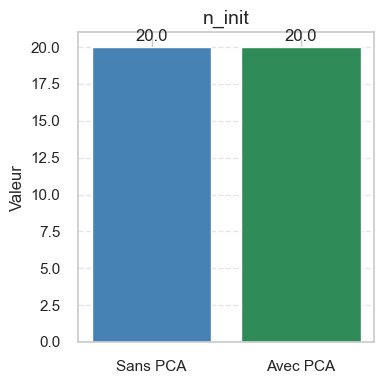

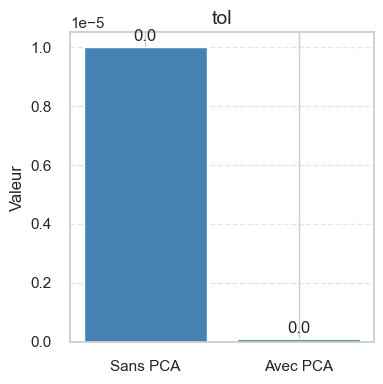

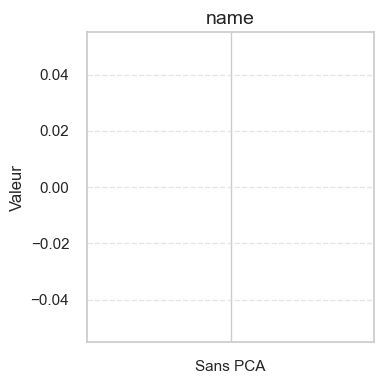

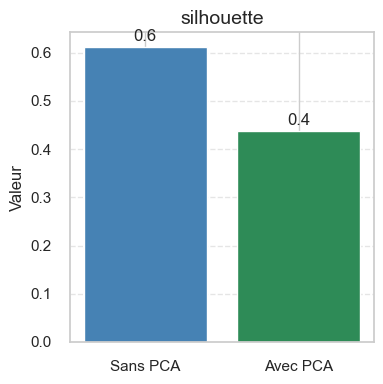

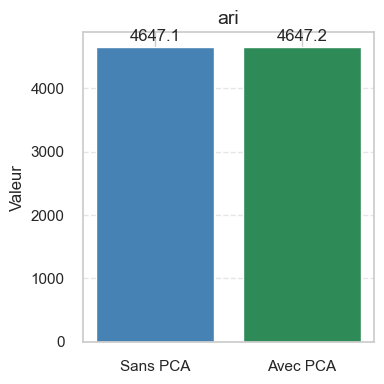

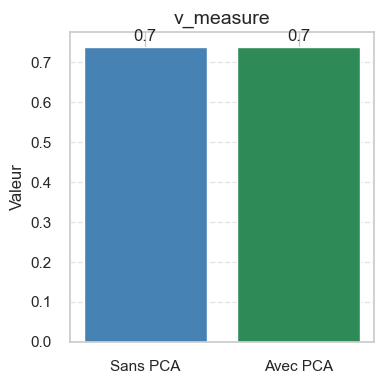

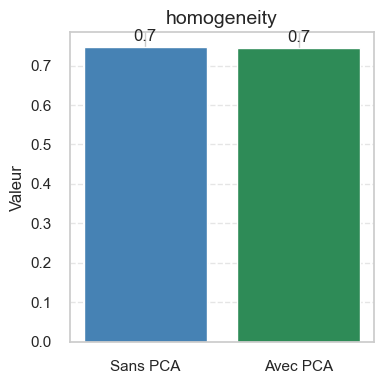

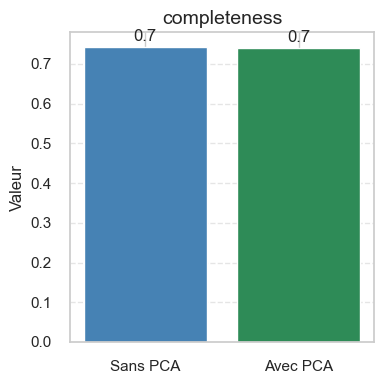

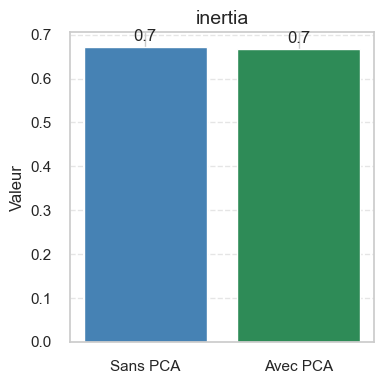

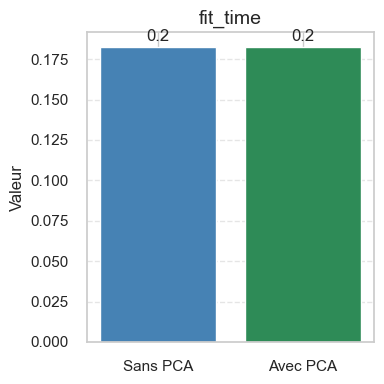

In [150]:
df = pd.DataFrame({"Sans PCA": best_silhouette_config, "Avec PCA": best_silhouette_config_pca})
df_numeric = df.drop(index="init")  # supprimer le champ non numérique
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')  # Convertir


#  un graphique par métrique
for metric in df_numeric.index:
    plt.figure(figsize=(4, 4))
    values = df_numeric.loc[metric]
    

    plt.bar(["Sans PCA", "Avec PCA"], values, color=["steelblue", "seagreen"])
    
    plt.title(metric)
    for i, val in enumerate(values):
        plt.text(i, val + max(values) * 0.02, f'{val:.1f}', ha='center')
    
    plt.ylabel("Valeur")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Globalement l'analyse en composante principale permet d'avoir de meilleurs performances , même silhouette score à bondit d'environ 10%.
Le probleme viens peut-être de la méthode k-mean en elle même.
sans pca  la tolerence est nulle ce qui constitue la condition d'arret la plus stricte possible mais même malgrés cela les metriques sont pas bonnes

# Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)

Avec standardisation on peut tester d'autres metriques, on pourra ecrire une fonction qui prend la methode de standardisation en arument
En attendant nous restons avec ce qui a deja été fait, examinons à present le cas de non standardisation
Un meilleur travail consistait à anticiper les questions  en creant des fonctions avec pleins de parametres afin d'eviter de copier coller du code mais bon ...


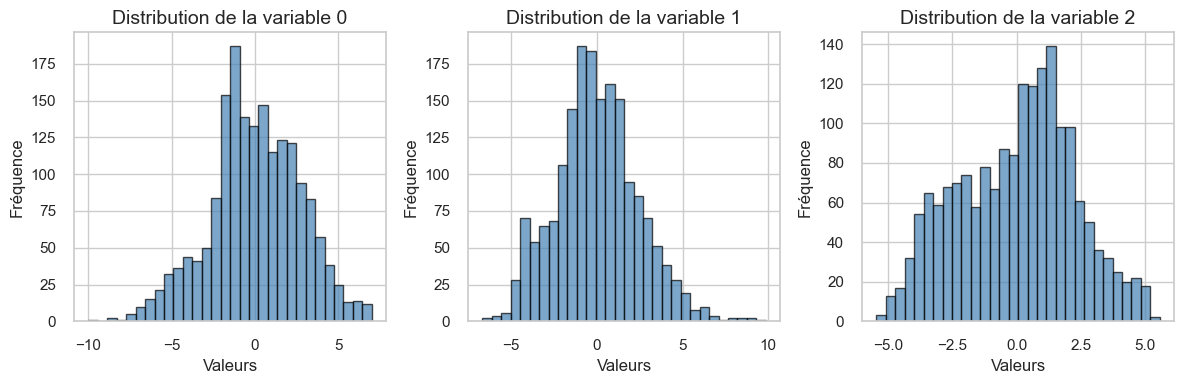

In [151]:

# Sélectionner quelques variables de X_scaled
variables = [0, 1, 2]  

plt.figure(figsize=(12, 4))

for i, var in enumerate(variables, 1):
    plt.subplot(1, len(variables), i)
    plt.hist(X_pca[:, var], bins=30, alpha=0.7, color="steelblue", edgecolor="black")
    plt.title(f"Distribution de la variable {var}")
    plt.xlabel("Valeurs")
    plt.ylabel("Fréquence")
    
plt.tight_layout()
plt.show()

> clairement  pas de standardisation

In [152]:

# Standardisation= False
X_scaled = X_pca  #  sans standardisation
# Les parametres à optimiser
param_grid = {
    'n_clusters': [10,11],## 10 ou 11 mais de preference on ne gardera que ceux avec 10
    'n_init': [5,10,15,20],
    'init': ['k-means++','random'],
    'max_iter': [100,200,300,400,500],
    'tol': [1e-3, 1e-5, 1e-6,1e-7,1e-10]
}
all_results = []
for params in ParameterGrid(param_grid):
    kmeans = KMeans(random_state=221, **params)
    name = (
        f"k={params['n_clusters']}, init={params['init']}, "
        f"n_init={params['n_init']}, max_iter={params['max_iter']}, tol={params['tol']}"
    )
    res = bench_k_means(kmeans, name, X, labels)
    all_results.append({"params": params, "results": res})

df = pd.DataFrame(all_results)


k=10, init=k-means++, n_init=5, max_iter=100, tol=0.001	0.125s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-05	0.091s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-06	0.118s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-07	0.101s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=5, max_iter=100, tol=1e-10	0.120s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=0.001	0.158s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-05	0.204s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-06	0.188s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-07	0.212s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-means++, n_init=10, max_iter=100, tol=1e-10	0.180s	4648	0.738	0.746	0.742	0.668	0.183
k=10, init=k-me

In [153]:
#copier_coller

def extract_results(df):
    """
    Transforme la colonne df['results'] (liste) en DataFrame 
    """
    cols = [
        "name",       
        "fit_time",
        "inertia",
        "homogeneity",
        "completeness",
        "v_measure",
        "ari",
        "silhouette",
    ]
    return pd.DataFrame(df["results"].tolist(), columns=cols)

#  Fusion avec les hyperparamètres
def build_viz_df(df, results_df):
    """
    Concatène params (dict) et résultats (DataFrame) en un seul DataFrame.
    """
    params_df = df["params"].apply(pd.Series)
    return pd.concat([params_df, results_df], axis=1)


results_df = extract_results(df)
df_viz      = build_viz_df(df, results_df)



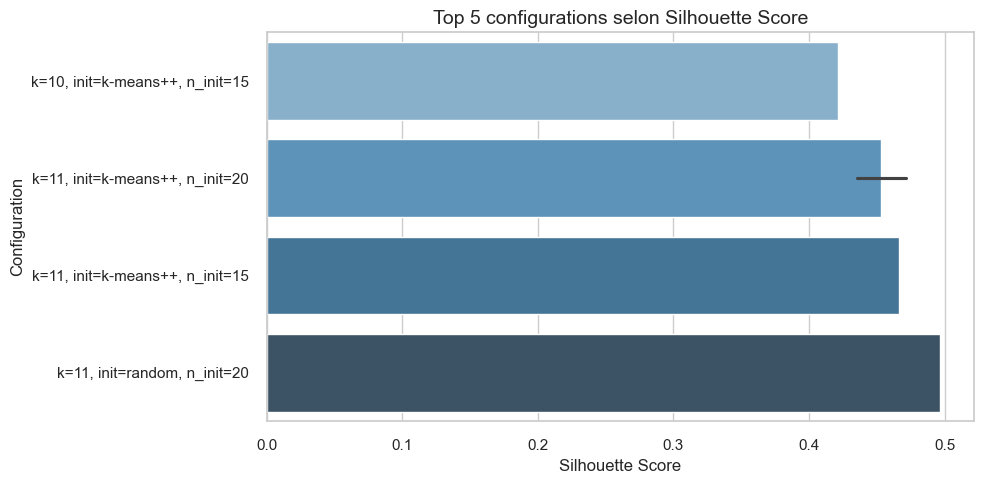

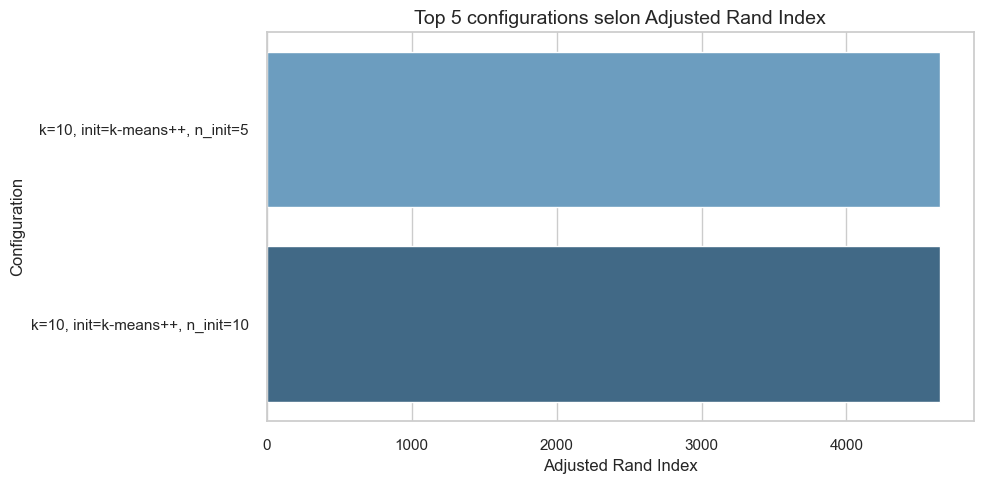

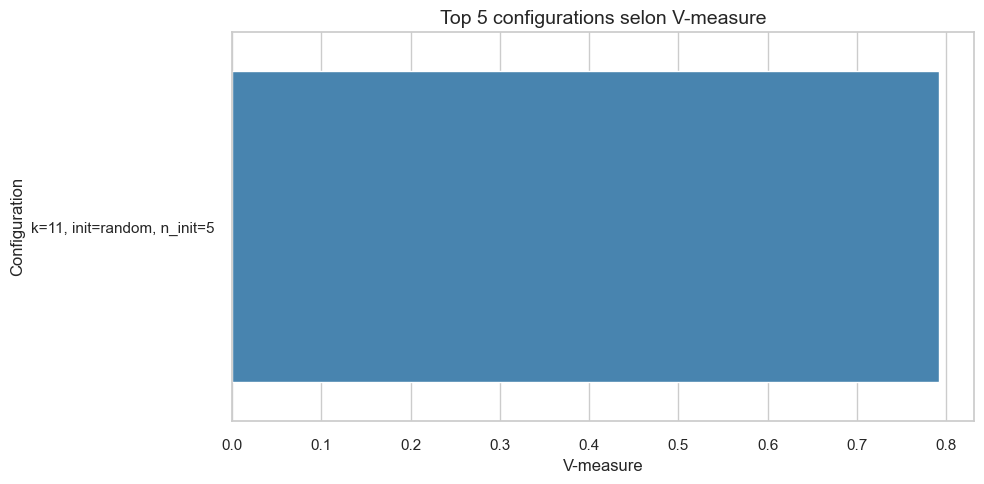

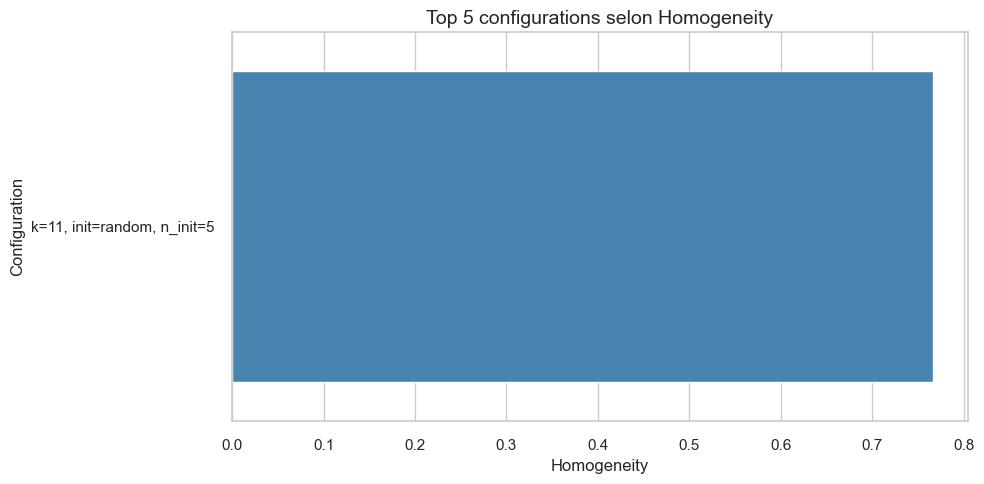

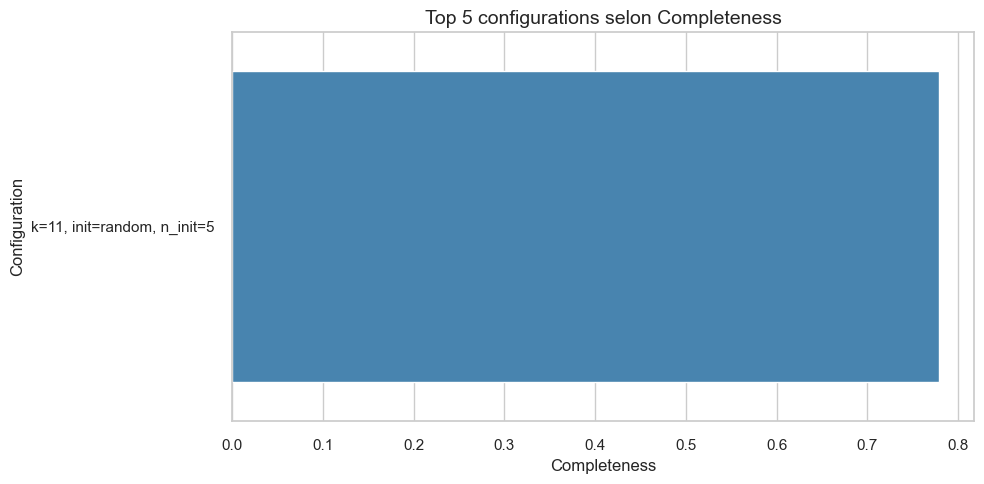

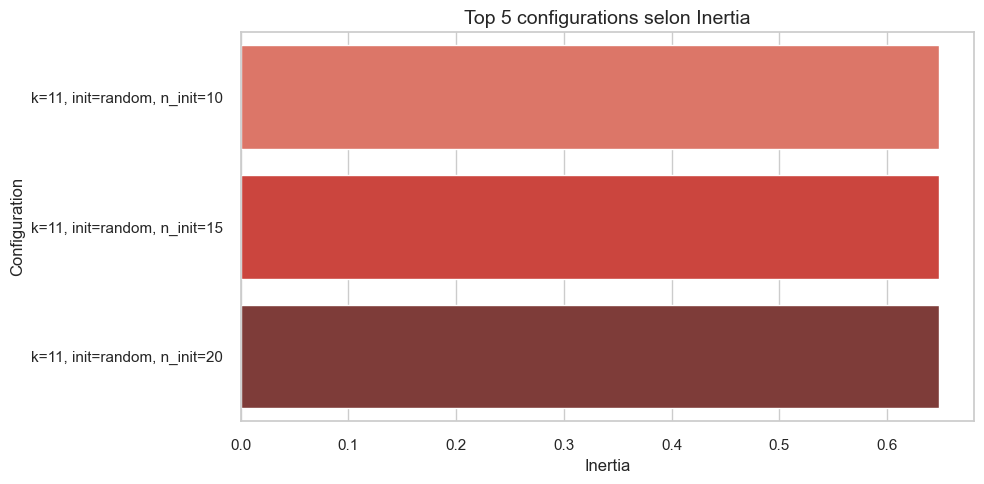

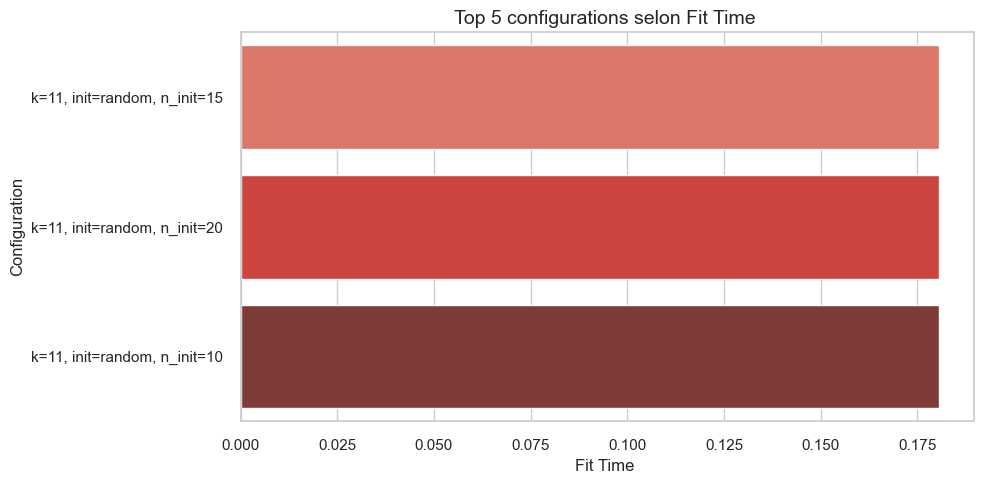

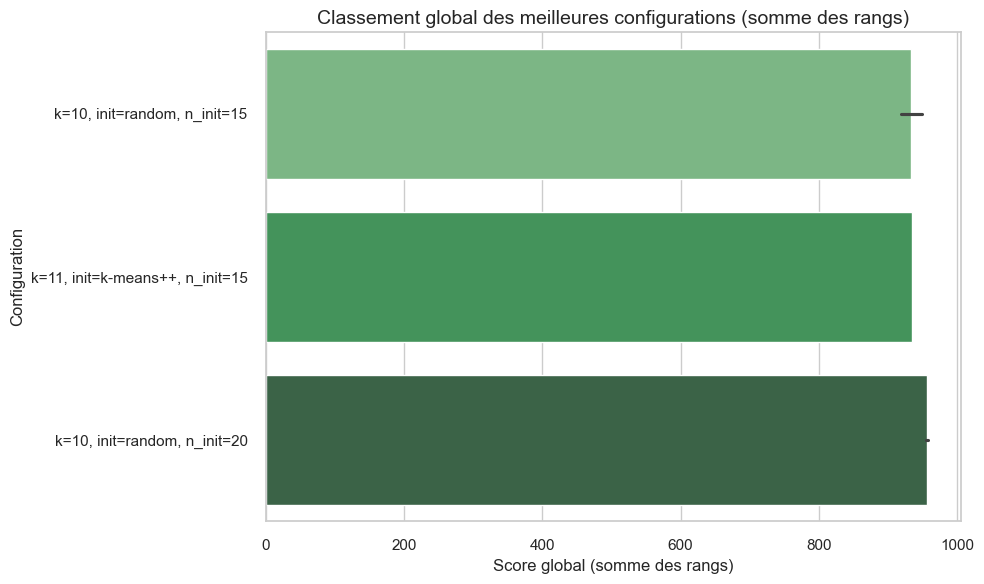

In [154]:
# Si il y a des exequo alors seul le premier est affiche ce qui fait qu'on a pas systematiquement 5 graphiques
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

#  métriques et sens d'optimisation
# True si l'on veux minimiser
metrics_info = {
    "silhouette":    {"ascending": False, "label": "Silhouette Score"},
    "ari":           {"ascending": False, "label": "Adjusted Rand Index"},
    "v_measure":     {"ascending": False, "label": "V-measure"},
    "homogeneity":   {"ascending": False, "label": "Homogeneity"},
    "completeness":  {"ascending": False, "label": "Completeness"},
    "inertia":       {"ascending": True,  "label": "Inertia"},
    "fit_time":      {"ascending": True,  "label": "Fit Time "}
}

top_n = 5
metrics_cols = list(metrics_info.keys())
results_df = pd.DataFrame(df["results"].tolist(), columns=["name"] + metrics_cols)
params_df = df["params"].apply(pd.Series)
df_viz = pd.concat([params_df, results_df], axis=1)

# afficher les top configurations
def plot_top_configs(metric, label, ascending):
    threshold = df_viz[metric].sort_values(ascending=ascending).iloc[top_n - 1]
    if ascending:
        top_df = df_viz[df_viz[metric] <= threshold].copy()
    else:
        top_df = df_viz[df_viz[metric] >= threshold].copy()

    top_df["config"] = top_df.apply(
        lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
    )
    
    # Tracé
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=top_df,
        y="config",
        hue="config",
        x=metric,
        palette="Blues_d" if not ascending else "Reds_d"
    )
    plt.title(f"Top {top_n} configurations selon {label}")
    plt.xlabel(label)
    plt.ylabel("Configuration")
    plt.tight_layout()
    plt.show()

for metric, info in metrics_info.items():
    plot_top_configs(metric, info["label"], info["ascending"])

# Création d’un tableau de rangs pour toutes les métriques
ranks = pd.DataFrame(index=df_viz.index)

for metric, info in metrics_info.items():
    ranks[metric] = df_viz[metric].rank(ascending=info["ascending"], method="min")


# Ajout des paramètres pour identification
ranks["config"] = df_viz.apply(
    lambda row: f"k={row['n_clusters']}, init={row['init']}, n_init={row['n_init']}", axis=1
)

# Calcul du score global : somme des rangs
# Une configuration qui est la meilleure sur une métrique obtient le rang 1, la 2iem le rang 2, etc

ranks["total_rank"] = ranks[list(metrics_info.keys())].sum(axis=1)
ranks_sorted = ranks.sort_values("total_rank").reset_index(drop=True)


# Visualisation des performances globales
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ranks_sorted.head(top_n),
    y="config",
    hue='config',
    x="total_rank",
    palette="Greens_d"
)
plt.title("Classement global des meilleures configurations (somme des rangs)")
plt.xlabel("Score global (somme des rangs)")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


In [155]:
best_silhouette_config_no_standard = df_viz.loc[df_viz["silhouette"].idxmax()]
best_silhouette_config_no_standard


init                                                       random
max_iter                                                      400
n_clusters                                                     11
n_init                                                         20
tol                                                           0.0
name            k=11, init=random, n_init=20, max_iter=400, to...
silhouette                                               0.496786
ari                                                   4520.283554
v_measure                                                 0.74663
homogeneity                                              0.728794
completeness                                             0.737605
inertia                                                  0.648217
fit_time                                                  0.18064
Name: 358, dtype: object

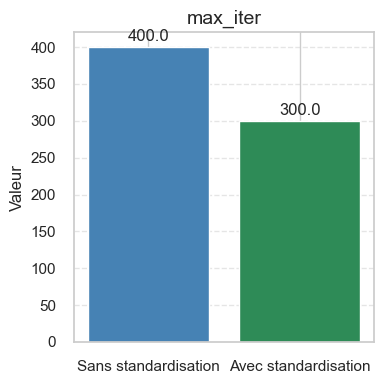

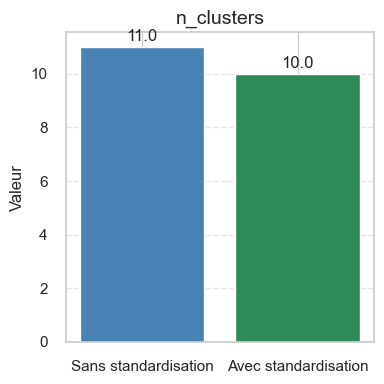

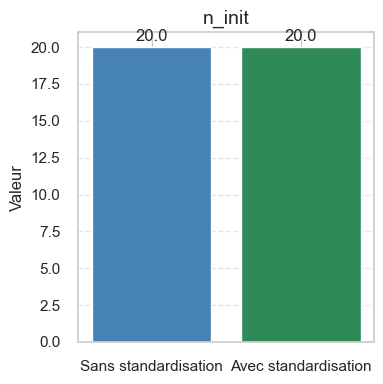

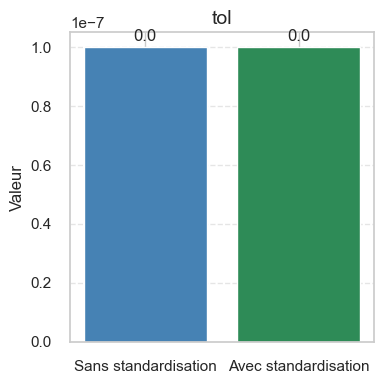

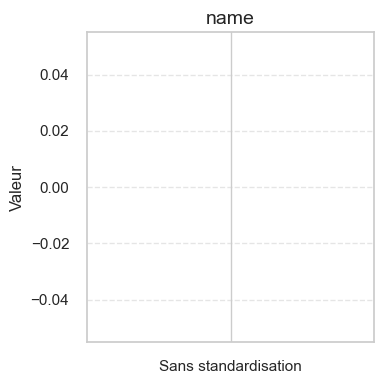

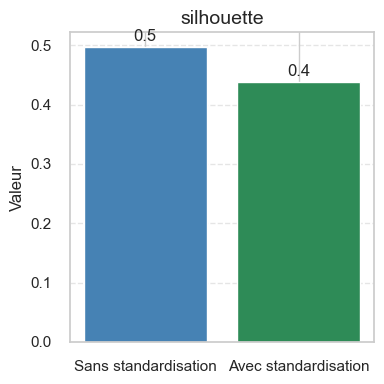

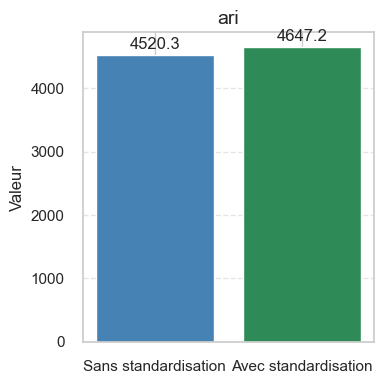

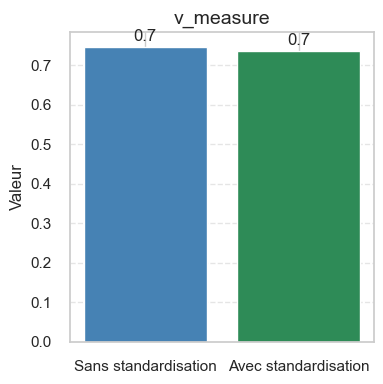

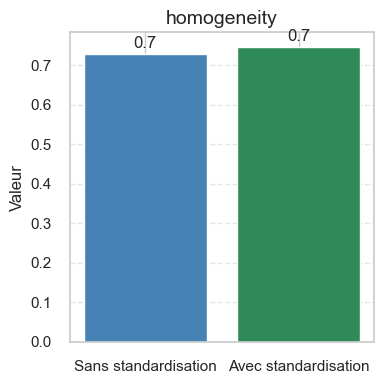

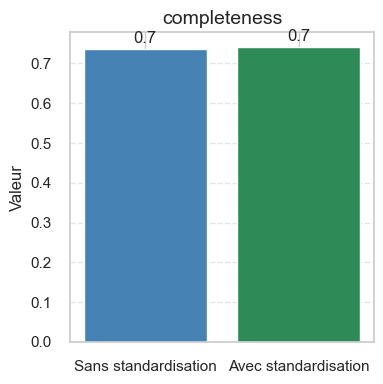

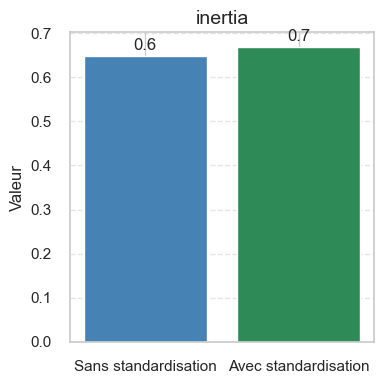

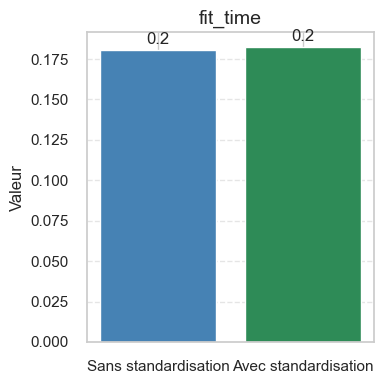

In [156]:
df = pd.DataFrame({"Sans standardisation": best_silhouette_config_no_standard, "Avec standardisation": best_silhouette_config_pca})
df_numeric = df.drop(index="init")  # supprimer le champ non numérique
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')  # Convertir


#  un graphique par métrique
for metric in df_numeric.index:
    plt.figure(figsize=(4, 4))
    values = df_numeric.loc[metric]
    

    plt.bar(["Sans standardisation", "Avec standardisation"], values, color=["steelblue", "seagreen"])
    
    plt.title(metric)
    for i, val in enumerate(values):
        plt.text(i, val + max(values) * 0.02, f'{val:.1f}', ha='center')
    
    plt.ylabel("Valeur")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Environ deux fois plus d'iteration pour un score bien inferieure conclusion: k-means est tres sensible à la standardisation donc toujours en faire

# - Faire l'analyse des personnas pour le meilleur modèle

In [157]:
best_silhouette_config_pca

init                                                    k-means++
max_iter                                                      300
n_clusters                                                     10
n_init                                                         20
tol                                                           0.0
name            k=10, init=k-means++, n_init=20, max_iter=300,...
silhouette                                               0.437609
ari                                                    4647.17016
v_measure                                                0.737163
homogeneity                                              0.745314
completeness                                             0.741216
inertia                                                  0.668133
fit_time                                                  0.18238
Name: 98, dtype: object

In [ ]:
#  le meilleur model et ses labels
best_kmeans = KMeans(
    n_clusters=best_silhouette_config_pca["n_clusters"], 
    init=best_silhouette_config_pca["init"], 
    n_init=best_silhouette_config_pca["n_init"], 
    max_iter=best_silhouette_config_pca["max_iter"], 
    tol=best_silhouette_config_pca["tol"], 
    random_state=221
)
pipeline = make_pipeline(MinMaxScaler(), best_kmeans).fit(X_pca) # super important on prend X_pca a la place de X
labels_clusters= pipeline[-1].labels_


In [ ]:
# Les seuls colonnes qui importent c'est label et cluster
data.head()# on reprend notre data initial

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,8
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,1
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,4
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,7


In [160]:
# add du label des clusters
data["cluster_pca"] = labels_clusters  
print(data["cluster"].unique())  
print(data["cluster"].value_counts())  # la répartition des clusters



[0 8 1 4 7 6 5 9 3 2]
cluster
1    226
5    213
9    208
3    192
2    178
7    174
0    173
6    170
4    147
8    116
Name: count, dtype: int64


Le silhouette score est une metrique qui permet de savoir à quel point un point est bien placé dans son cluster.
Chaque observation dans data possède un label cluster_pca, qui lui indique à quel groupe elle appartient.
On va calculer ce score dans chaque cluster afin de savoir à quel quels sont les clusters qui sont bien representé ou pas

In [161]:
from sklearn import metrics
import pandas as pd

# Taille et silhouette score moyenne par cluster

# nombre d'éléments par cluster
summary_size = data.groupby("cluster_pca").size().rename("count")

# calcul des silhouette score pour chaque point
silhouette_scores = metrics.silhouette_samples(
    X_pca, 
    data["cluster_pca"]
)

data["silhouette"] = silhouette_scores

#score de silhouette moyen par cluster
summary_silhouette = (
    data
    .groupby("cluster_pca")["silhouette"]
    .mean()
    .rename("mean_silhouette")
)

cluster_stats = pd.concat([summary_size, summary_silhouette], axis=1)

print(cluster_stats)


             count  mean_silhouette
cluster_pca                        
0              180         0.356283
1              194         0.110710
2              175         0.264783
3              153         0.027760
4              153         0.102840
5              220         0.195162
6               46         0.282212
7              139         0.166047
8              434         0.129077
9              103         0.185345


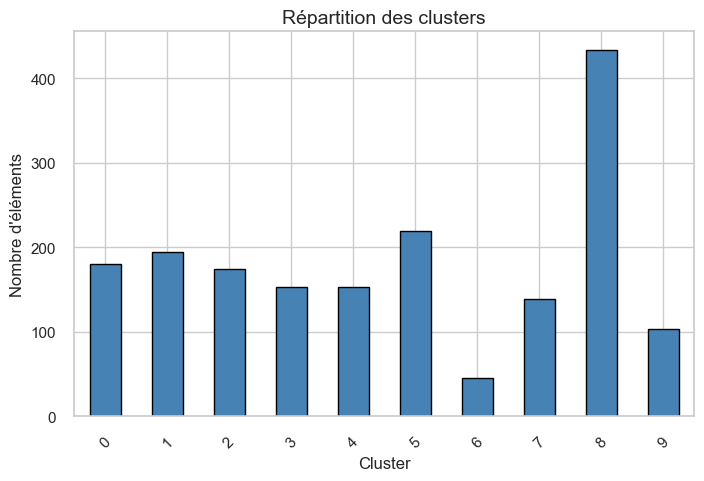

In [162]:
# Histogramme de la taille des clusters
plt.figure(figsize=(8, 5))
cluster_stats["count"].plot(kind="bar", color="steelblue", edgecolor="black")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'éléments")
plt.title("Répartition des clusters")
plt.xticks(rotation=45)
plt.show() # on a un clusters que le modéle a trop donnée en importance

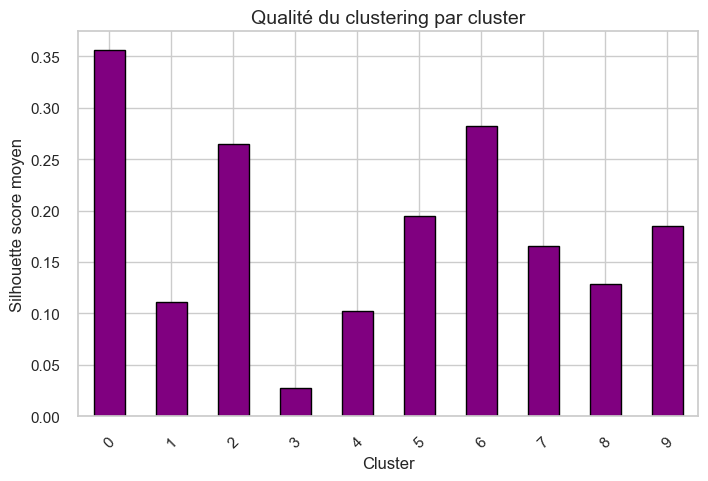

In [163]:
#Moyenne du silhouette score par cluster
plt.figure(figsize=(8, 5))
cluster_stats["mean_silhouette"].plot(kind="bar", color="purple", edgecolor="black")
plt.xlabel("Cluster")
plt.ylabel("Silhouette score moyen")
plt.title("Qualité du clustering par cluster")
plt.xticks(rotation=45)
plt.show() # les clusters 1 0 4 et 7  intersectent d'autres clusters

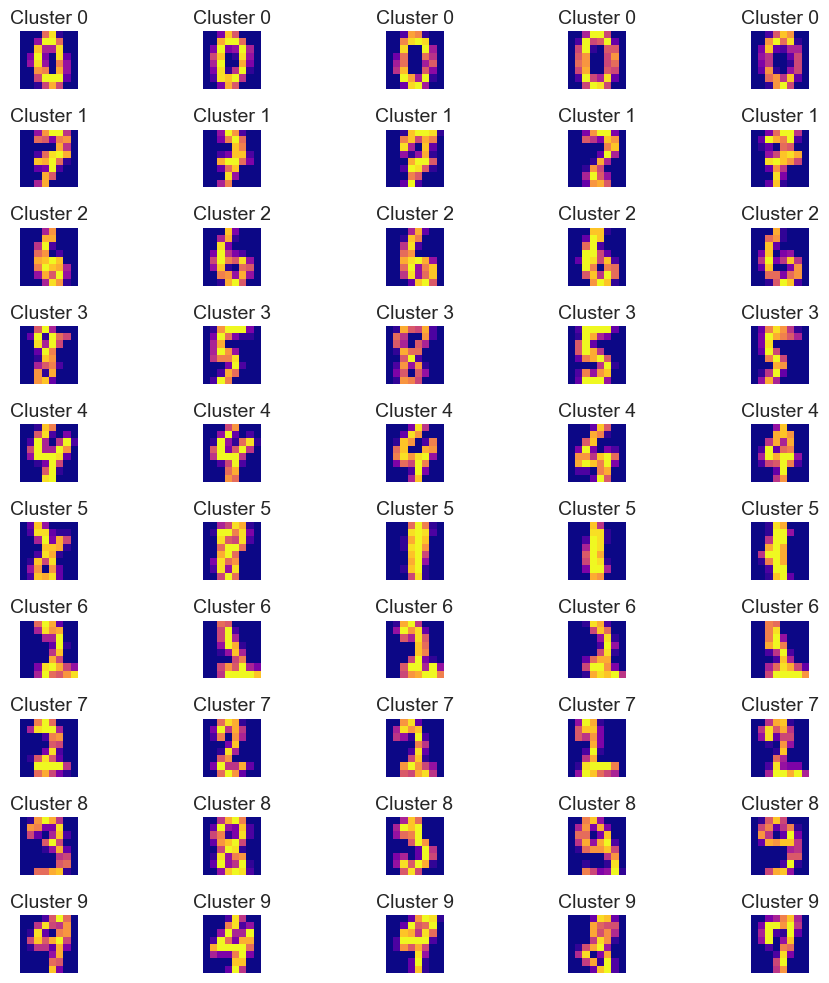

In [164]:

n_images = 5

fig, axes = plt.subplots(data["cluster_pca"].nunique(), n_images, figsize=(10, 10))

for i, cluster_id in enumerate(sorted(data["cluster_pca"].unique())):
    # Sélectionner aléatoirement 5 images du cluster
    sample_images = data[data["cluster_pca"] == cluster_id].sample(n_images, random_state=42).index

    for j, img_index in enumerate(sample_images):
        axes[i, j].imshow(X[img_index].reshape(8, 8), cmap="plasma")  
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Cluster {cluster_id}")

plt.tight_layout()
plt.show()

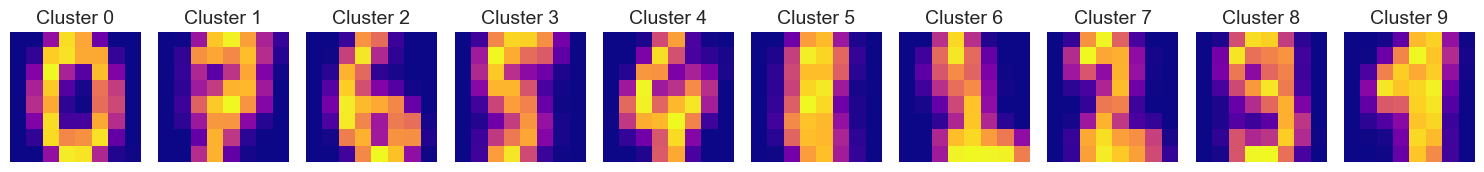

In [165]:
#  les images moyennes de chaque cluster

fig, axes = plt.subplots(1, data["cluster_pca"].nunique(), figsize=(15,18)) 

for i, cluster_id in enumerate(sorted(data["cluster_pca"].unique())):
    mean_image = X[data["cluster_pca"] == cluster_id].mean(axis=0)

    axes[i].imshow(mean_image.reshape(8, 8), cmap="plasma") 
    axes[i].axis("off")
    axes[i].set_title(f"Cluster {cluster_id}")

plt.tight_layout()
plt.show()

In [166]:

cluster_label_counts = pd.crosstab(data["cluster_pca"], data["label"])


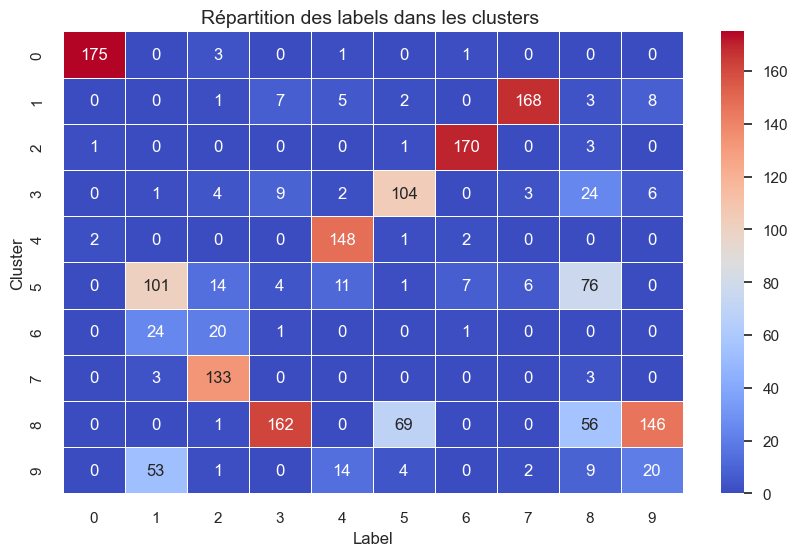

In [167]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_label_counts, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)
plt.xlabel("Label")
plt.ylabel("Cluster")
plt.title("Répartition des labels dans les clusters ")
plt.show()

Comme mentionnée, nous avons retenu 11 clusters.

notre modele confond beaucoup les chiffres 3 et 9 il les met tous dans le cluster 8
le cluster 9 semble être le cluster de trop il serais intessant de savoir pourquoi les 1 du cluster 9 ne sont pas dans le cluster 5 qui semble etre leur bonne place.

Ensuite, le silhouette score moyen par cluster évalue la cohésion et la séparation des groupes. Un score élevé indique un bon regroupement, tandis qu’un score faible traduit un chevauchement . Le cluster 9 affiche le meilleur score (0.36), ce qui correspond bien aux observations de la heatmap : il contient peu de labels différents et sa structure est bien définie. Les clusters 8, 3, 2, 5 et 6 présentent également des scores acceptables (>0.2), indiquant une segmentation correcte. À l’inverse, les clusters 1, 0, 4 et 7 ont des scores beaucoup plus bas (0.01 à 0.13), ce qui suggère un mauvais regroupement ou une séparation inefficace entre certaines classes.

dans le cluster 6 les label 1 et 2 sont les plus present .
Comme on a fait une ACP il nous est impossible de reconstituer les images à partir des composantes ACP ce qui fait que même si on peut aisement les individus qui posent probleme on ne peut pas totalement assigner leur mauvais classement uniquement à leur forme atypique au seuil de leur label, peut être que c'est la parte d'information due à l'ACP qui est la source de ces mauvais classement.

Analyser quelle variable influence un cluster ou identifier les caractéristiques les plus déterminantes n’a pas de sens ici, car les colonnes représentent des valeurs de pixels (  des données brutes d’image sans signification directe en termes de classification). De plus, comme nous avons appliqué un PCA, les dimensions ont été transformées, les pixels individuels ne sont plus directement interprétables.

Dans ce contexte, plutôt que d’examiner l’impact de chaque variable, une approche plus pertinente serait de visualiser les images moyennes de chaque cluster et d’analyser leur répartition statistique pour détecter des formes ou motifs distinctifs.  C'est ce qui justifie notre approche
